# 多分类SVM-Iris分类+Tracin计算

一个简单的Iris-SVM实现，基于cs231n的linear_svm代码，将数据集替换为Iris。用此代码目的是：
1.不是完全调包，有充分展示SVM的源代码；
2.Loss和grand显式打印可调，便于计算tracin-score；
3.替换成简单数据，为了保证可解释性，避免图片分类特征提取造成的误差；

In [1]:
# 基本包与配置
import random
import numpy as np   
from  sklearn  import datasets,cross_validation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Iris加载并处理

In [2]:
# 直接从sklearn库调用Iris，train:test=3:1
iris=datasets.load_iris()
X_train=iris.data
y_train=iris.target
X_train, X_test,y_train,y_test =cross_validation.train_test_split(X_train,y_train,test_size=0.25,random_state=0,stratify=y_train)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (112, 4)
Training labels shape:  (112,)
Test data shape:  (38, 4)
Test labels shape:  (38,)


In [3]:
# 这里多搞一些操作：首先，把train分出val集，同时把train中一部分随机挑出作为dev集
num_training = 100
num_validation = 12
num_test = 38
num_dev = 50

# 验证集将是原始训练集挑选的num_val
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

#我们的训练集是原始训练集的第一个num_训练点
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (100, 4)
Train labels shape:  (100,)
Validation data shape:  (12, 4)
Validation labels shape:  (12,)
Test data shape:  (38, 4)
Test labels shape:  (38,)


In [4]:
# 预处理：3维特征降维至2维，iris无需该操作
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (100, 4)
Validation data shape:  (12, 4)
Test data shape:  (38, 4)
dev data shape:  (50, 4)


In [5]:
#预处理：均值归一
mean_image = np.mean(X_train, axis=0)

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [7]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(100, 5) (12, 5) (38, 5) (50, 5)


## SVM Classifier
`svm_loss_naive` ：该函数用于循环评估多类支持向量机损失函数。 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(5,3) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('grad is {}'.format(grad))
print('loss: %f' % (loss, ))

grad is [[ 0.8431   0.01204 -0.85514]
 [-0.2948   0.25408  0.04072]
 [ 2.202   -0.3396  -1.8624 ]
 [ 0.9568  -0.05768 -0.89912]
 [ 0.1      0.04    -0.14   ]]
loss: 1.999445


上述函数返回grad全部为零。推导并实现支持向量机代价函数的梯度，并在函数“SVM\u loss\u naive”内内联实现。您会发现在现有函数中插入新代码很有帮助。
为了检查您是否正确地实现了梯度，您可以对损失函数的梯度进行数值估计，并将数值估计与您计算的梯度进行比较。我们为您提供了执行此操作的代码：

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.202000 analytic: 2.202000, relative error: 1.000007e-12
numerical: -1.862400 analytic: -1.862400, relative error: 5.078269e-12
numerical: -0.140000 analytic: -0.140000, relative error: 1.838763e-10
numerical: 0.254080 analytic: 0.254080, relative error: 1.650409e-10
numerical: -0.057680 analytic: -0.057680, relative error: 8.328513e-11
numerical: 0.254080 analytic: 0.254080, relative error: 1.650409e-10
numerical: 0.843100 analytic: 0.843100, relative error: 1.133333e-11
numerical: 0.012040 analytic: 0.012040, relative error: 1.248607e-10
numerical: -0.057680 analytic: -0.057680, relative error: 8.328513e-11
numerical: 0.254080 analytic: 0.254080, relative error: 1.650409e-10
numerical: -0.066340 analytic: -0.066340, relative error: 3.130621e-11
numerical: 0.250536 analytic: 0.250536, relative error: 1.765696e-10
numerical: 0.032484 analytic: 0.032484, relative error: 1.574327e-10
numerical: 0.250536 analytic: 0.250536, relative error: 1.765696e-10
numerical: 0.087748 anal

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *A discrepancy may be caused when the loss function is not differentiable at some points. For example, the function ReLU $f(x) = max(0,x)$ is not differetiable at x=0. The formula for the numerical gradient is $\frac{df(x)}{dx} = \frac{f(x+h)-f(x-h)}{2*h}$. Using this formula, the numerical gradients is $f'(\frac{h}{2}) = \frac{3}{4}$, while the analytic gradient is $f'(\frac{h}{2}) = 1$. Thus, a large discrtpancy is caused at the point near $x=0$*

In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.999445e+00 computed in 0.000999s
Vectorized loss: 1.999445e+00 computed in 0.001000s
difference: 0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.000000s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from linear_classifier import LinearSVM
svm = LinearSVM()

tic = time.time()
loss_hist,grad_hist ,idx_hist= svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      batch_size=1,epochs=50, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

This is epoch 0
50660.55637823252 is score between train_sample [90] & test_sample [9] 
50621.94656163294 is score between train_sample [90] & test_sample [10] 
50688.79300310786 is score between train_sample [90] & test_sample [0] 
49750.95465684049 is score between train_sample [90] & test_sample [8] 
49751.416428138706 is score between train_sample [90] & test_sample [11] 
49746.011842687745 is score between train_sample [90] & test_sample [7] 
49382.01230200916 is score between train_sample [90] & test_sample [4] 
49479.52427614991 is score between train_sample [90] & test_sample [6] 
48467.841992293026 is score between train_sample [90] & test_sample [5] 
48243.891471444935 is score between train_sample [90] & test_sample [2] 
48367.59808600426 is score between train_sample [90] & test_sample [3] 
48625.13642033762 is score between train_sample [90] & test_sample [1] 
epoch: 0/50 sample: 90 loss: 2.508787
44579.93852799754 is score between train_sample [1] & test_sample [0] 
43726

1409.4534736406238 is score between train_sample [17] & test_sample [6] 
1292.404596801585 is score between train_sample [17] & test_sample [11] 
1250.2906928781424 is score between train_sample [17] & test_sample [2] 
1291.9805778199961 is score between train_sample [17] & test_sample [3] 
1344.190265434671 is score between train_sample [17] & test_sample [7] 
1285.6268596381678 is score between train_sample [17] & test_sample [4] 
1384.9567076843823 is score between train_sample [17] & test_sample [1] 
1214.8041501341436 is score between train_sample [17] & test_sample [5] 
1218.766020441154 is score between train_sample [17] & test_sample [9] 
1340.2807589603096 is score between train_sample [17] & test_sample [0] 
1203.6358168105 is score between train_sample [17] & test_sample [8] 
epoch: 0/50 sample: 17 loss: 2.013742
1152.6525315847916 is score between train_sample [98] & test_sample [3] 
1204.8621158815843 is score between train_sample [98] & test_sample [7] 
1128.965905407478 

15.925648840416734 is score between train_sample [15] & test_sample [9] 
26.724435516869033 is score between train_sample [15] & test_sample [4] 
epoch: 0/50 sample: 15 loss: 2.000504
31.61915042022757 is score between train_sample [54] & test_sample [8] 
7.062186640110802 is score between train_sample [54] & test_sample [3] 
32.27057598940963 is score between train_sample [54] & test_sample [5] 
13.620308986461275 is score between train_sample [54] & test_sample [0] 
28.829343413643198 is score between train_sample [54] & test_sample [2] 
4.691528393999573 is score between train_sample [54] & test_sample [11] 
19.647611120079343 is score between train_sample [54] & test_sample [6] 
3.3338390131085447 is score between train_sample [54] & test_sample [9] 
16.72073063176052 is score between train_sample [54] & test_sample [1] 
13.306788936385164 is score between train_sample [54] & test_sample [7] 
7.176744767307168 is score between train_sample [54] & test_sample [4] 
6.777460715634159 

-10.166868243108215 is score between train_sample [11] & test_sample [8] 
20.493916013497685 is score between train_sample [11] & test_sample [6] 
-4.438949352939708 is score between train_sample [11] & test_sample [10] 
-4.6051964432944645 is score between train_sample [11] & test_sample [11] 
21.05486311285302 is score between train_sample [11] & test_sample [1] 
-11.849359513254303 is score between train_sample [11] & test_sample [5] 
19.613384680205062 is score between train_sample [11] & test_sample [0] 
18.64731873456257 is score between train_sample [11] & test_sample [7] 
-8.969150652965205 is score between train_sample [11] & test_sample [2] 
-11.745682659029516 is score between train_sample [11] & test_sample [9] 
epoch: 0/50 sample: 11 loss: 2.000122
-5.3440143652248855 is score between train_sample [18] & test_sample [2] 
-9.410838018961734 is score between train_sample [18] & test_sample [10] 
-7.849178316008939 is score between train_sample [18] & test_sample [11] 
19.273

-8.400632247166168 is score between train_sample [39] & test_sample [8] 
-9.952463603718929 is score between train_sample [39] & test_sample [1] 
-9.064911354157736 is score between train_sample [39] & test_sample [0] 
15.181136959988631 is score between train_sample [39] & test_sample [3] 
13.910584577900599 is score between train_sample [39] & test_sample [4] 
-9.72515094591105 is score between train_sample [39] & test_sample [2] 
19.772314056001925 is score between train_sample [39] & test_sample [9] 
-8.60640229096523 is score between train_sample [39] & test_sample [5] 
-15.441824007038656 is score between train_sample [39] & test_sample [6] 
-13.247453869776379 is score between train_sample [39] & test_sample [7] 
epoch: 1/50 sample: 39 loss: 1.999784
-3.641941391925247 is score between train_sample [87] & test_sample [7] 
-9.261585215507278 is score between train_sample [87] & test_sample [9] 
21.71235709605287 is score between train_sample [87] & test_sample [2] 
18.75349070998

18.880025405983268 is score between train_sample [27] & test_sample [6] 
-6.576532147281401 is score between train_sample [27] & test_sample [11] 
17.41279161879542 is score between train_sample [27] & test_sample [0] 
-10.465443067023072 is score between train_sample [27] & test_sample [5] 
18.2164523058364 is score between train_sample [27] & test_sample [1] 
-7.316325042460441 is score between train_sample [27] & test_sample [10] 
-7.4997973333021895 is score between train_sample [27] & test_sample [3] 
17.52084094506618 is score between train_sample [27] & test_sample [7] 
-14.373004857428475 is score between train_sample [27] & test_sample [9] 
-7.034952342653236 is score between train_sample [27] & test_sample [4] 
-8.144271915340903 is score between train_sample [27] & test_sample [2] 
epoch: 1/50 sample: 27 loss: 2.000101
-2.5007125732316466 is score between train_sample [82] & test_sample [2] 
16.757792550921216 is score between train_sample [82] & test_sample [0] 
20.73584326

14.223100005242033 is score between train_sample [37] & test_sample [6] 
-19.71307041424204 is score between train_sample [37] & test_sample [5] 
-14.831637729425267 is score between train_sample [37] & test_sample [2] 
-1.0206723992457805 is score between train_sample [37] & test_sample [10] 
-17.493905493188464 is score between train_sample [37] & test_sample [8] 
epoch: 1/50 sample: 37 loss: 2.000099
-13.699655406812232 is score between train_sample [45] & test_sample [4] 
23.11747798140462 is score between train_sample [45] & test_sample [6] 
1.1007747526123985 is score between train_sample [45] & test_sample [5] 
1.5655966492378304 is score between train_sample [45] & test_sample [8] 
-25.50274128822864 is score between train_sample [45] & test_sample [9] 
-14.5423984613931 is score between train_sample [45] & test_sample [3] 
17.716807505949834 is score between train_sample [45] & test_sample [1] 
-14.88167429965322 is score between train_sample [45] & test_sample [10] 
20.383828

-8.524609613466874 is score between train_sample [7] & test_sample [11] 
-4.227048522724181 is score between train_sample [7] & test_sample [6] 
25.216887756997508 is score between train_sample [7] & test_sample [5] 
-9.620141901463855 is score between train_sample [7] & test_sample [1] 
-9.2275468763639 is score between train_sample [7] & test_sample [3] 
-8.653059266922543 is score between train_sample [7] & test_sample [4] 
24.59045225601185 is score between train_sample [7] & test_sample [2] 
23.150930646657066 is score between train_sample [7] & test_sample [8] 
-7.676864377283995 is score between train_sample [7] & test_sample [9] 
epoch: 2/50 sample: 7 loss: 1.999726
-2.780439170473765 is score between train_sample [9] & test_sample [6] 
20.880558444303894 is score between train_sample [9] & test_sample [2] 
-9.462666084883443 is score between train_sample [9] & test_sample [10] 
-9.117816804327722 is score between train_sample [9] & test_sample [3] 
-7.143905740166138 is score 

-9.454650405092842 is score between train_sample [25] & test_sample [2] 
-3.1483901854020147 is score between train_sample [25] & test_sample [1] 
-9.39958559227412 is score between train_sample [25] & test_sample [8] 
-1.9385303424822755 is score between train_sample [25] & test_sample [0] 
epoch: 2/50 sample: 25 loss: 1.999929
-8.968178982274972 is score between train_sample [57] & test_sample [8] 
-9.143966462681664 is score between train_sample [57] & test_sample [6] 
11.276888087877786 is score between train_sample [57] & test_sample [3] 
-7.601800123464823 is score between train_sample [57] & test_sample [7] 
-4.600845348681378 is score between train_sample [57] & test_sample [0] 
10.799181445174439 is score between train_sample [57] & test_sample [4] 
-9.403521221294831 is score between train_sample [57] & test_sample [5] 
-5.277161210833558 is score between train_sample [57] & test_sample [1] 
13.299223248178967 is score between train_sample [57] & test_sample [9] 
-10.23120622

13.206921906461739 is score between train_sample [68] & test_sample [3] 
-7.792566883476285 is score between train_sample [68] & test_sample [8] 
13.778144499400838 is score between train_sample [68] & test_sample [11] 
-16.626157113164897 is score between train_sample [68] & test_sample [6] 
21.246374604008047 is score between train_sample [68] & test_sample [9] 
-11.947740024920694 is score between train_sample [68] & test_sample [1] 
-9.687793479872932 is score between train_sample [68] & test_sample [0] 
-7.269250787438344 is score between train_sample [68] & test_sample [2] 
-7.682055477118365 is score between train_sample [68] & test_sample [5] 
13.853233382791743 is score between train_sample [68] & test_sample [4] 
epoch: 2/50 sample: 68 loss: 1.999790
26.46909141183893 is score between train_sample [33] & test_sample [8] 
-6.0098176901888625 is score between train_sample [33] & test_sample [6] 
-12.163184675452928 is score between train_sample [33] & test_sample [0] 
-8.811451

18.836479936003403 is score between train_sample [38] & test_sample [7] 
-12.33216168507226 is score between train_sample [38] & test_sample [10] 
21.44609494548714 is score between train_sample [38] & test_sample [6] 
-3.2547663526685824 is score between train_sample [38] & test_sample [2] 
-2.332623691494283 is score between train_sample [38] & test_sample [8] 
-21.930756884281653 is score between train_sample [38] & test_sample [9] 
-10.265695999816337 is score between train_sample [38] & test_sample [11] 
-12.008749858885464 is score between train_sample [38] & test_sample [3] 
18.01565660440639 is score between train_sample [38] & test_sample [1] 
16.811577494688468 is score between train_sample [38] & test_sample [0] 
-3.021805204692872 is score between train_sample [38] & test_sample [5] 
-11.43307480578698 is score between train_sample [38] & test_sample [4] 
epoch: 3/50 sample: 38 loss: 2.000101
-7.9283999433821375 is score between train_sample [76] & test_sample [8] 
-16.1205

-7.205679229765179 is score between train_sample [99] & test_sample [4] 
17.79232760461578 is score between train_sample [99] & test_sample [1] 
-8.83786758819395 is score between train_sample [99] & test_sample [5] 
18.95249357722061 is score between train_sample [99] & test_sample [6] 
17.512635232307918 is score between train_sample [99] & test_sample [7] 
17.103373407465902 is score between train_sample [99] & test_sample [0] 
-7.997105878011967 is score between train_sample [99] & test_sample [2] 
-15.493317793627497 is score between train_sample [99] & test_sample [9] 
-7.674127144644972 is score between train_sample [99] & test_sample [8] 
-8.15903075074594 is score between train_sample [99] & test_sample [10] 
-6.6426688200596296 is score between train_sample [99] & test_sample [11] 
-8.058311029332465 is score between train_sample [99] & test_sample [3] 
epoch: 3/50 sample: 99 loss: 2.000108
-9.336507608414806 is score between train_sample [25] & test_sample [8] 
9.18615049427

-8.466913339276047 is score between train_sample [58] & test_sample [9] 
-9.32813429687235 is score between train_sample [58] & test_sample [10] 
21.781781743123712 is score between train_sample [58] & test_sample [5] 
-7.243928171561282 is score between train_sample [58] & test_sample [1] 
-7.821641940407257 is score between train_sample [58] & test_sample [11] 
-8.78915122821976 is score between train_sample [58] & test_sample [3] 
-7.865010823808656 is score between train_sample [58] & test_sample [4] 
-3.307809329737478 is score between train_sample [58] & test_sample [7] 
20.348452750296534 is score between train_sample [58] & test_sample [8] 
22.530117452814018 is score between train_sample [58] & test_sample [2] 
-2.5887407349497846 is score between train_sample [58] & test_sample [6] 
epoch: 3/50 sample: 58 loss: 1.999784
-8.68541773867698 is score between train_sample [86] & test_sample [10] 
-5.6364774763064425 is score between train_sample [86] & test_sample [7] 
23.82882384

-5.075337248534101 is score between train_sample [71] & test_sample [7] 
-8.230163164430143 is score between train_sample [71] & test_sample [11] 
-10.685510335277682 is score between train_sample [71] & test_sample [10] 
-7.316335813982249 is score between train_sample [71] & test_sample [1] 
-2.3014349947563915 is score between train_sample [71] & test_sample [6] 
20.38791826223917 is score between train_sample [71] & test_sample [8] 
-9.178296884018255 is score between train_sample [71] & test_sample [9] 
-9.768081056899819 is score between train_sample [71] & test_sample [3] 
-8.700909447568687 is score between train_sample [71] & test_sample [0] 
26.494621283633773 is score between train_sample [71] & test_sample [2] 
21.816241592572375 is score between train_sample [71] & test_sample [5] 
-9.391307198550907 is score between train_sample [71] & test_sample [4] 
epoch: 4/50 sample: 71 loss: 1.999741
-4.84166102366564 is score between train_sample [14] & test_sample [7] 
21.91880850

23.757181456880623 is score between train_sample [55] & test_sample [2] 
-5.704518930199399 is score between train_sample [55] & test_sample [6] 
-7.662146480376505 is score between train_sample [55] & test_sample [9] 
-6.730007803005927 is score between train_sample [55] & test_sample [7] 
-8.985580716850727 is score between train_sample [55] & test_sample [11] 
-8.691001399267007 is score between train_sample [55] & test_sample [4] 
25.818442084587833 is score between train_sample [55] & test_sample [5] 
-9.657992136509998 is score between train_sample [55] & test_sample [10] 
-11.121319332883896 is score between train_sample [55] & test_sample [1] 
-9.234862797180053 is score between train_sample [55] & test_sample [3] 
-11.290042315829812 is score between train_sample [55] & test_sample [0] 
23.83530756872925 is score between train_sample [55] & test_sample [8] 
epoch: 4/50 sample: 55 loss: 1.999711
-22.262932724343877 is score between train_sample [24] & test_sample [7] 
-6.297037

18.29346157517064 is score between train_sample [89] & test_sample [6] 
-8.536599264248727 is score between train_sample [89] & test_sample [8] 
-8.205147015107316 is score between train_sample [89] & test_sample [4] 
-14.967068569753835 is score between train_sample [89] & test_sample [9] 
17.167598029993417 is score between train_sample [89] & test_sample [1] 
-7.557359567407617 is score between train_sample [89] & test_sample [11] 
-9.694481457916812 is score between train_sample [89] & test_sample [5] 
18.33483465615608 is score between train_sample [89] & test_sample [7] 
-7.225897228228475 is score between train_sample [89] & test_sample [2] 
-8.3245199884731 is score between train_sample [89] & test_sample [3] 
-7.906452676546175 is score between train_sample [89] & test_sample [10] 
epoch: 4/50 sample: 89 loss: 2.000095
9.03733522452366 is score between train_sample [94] & test_sample [3] 
-8.704324366288414 is score between train_sample [94] & test_sample [2] 
-4.9372279590282

-13.159407766281427 is score between train_sample [90] & test_sample [7] 
13.737073865909219 is score between train_sample [90] & test_sample [4] 
13.677117622905833 is score between train_sample [90] & test_sample [3] 
-14.889578941622695 is score between train_sample [90] & test_sample [6] 
-9.8795337080383 is score between train_sample [90] & test_sample [1] 
19.448886875591697 is score between train_sample [90] & test_sample [9] 
epoch: 5/50 sample: 90 loss: 1.999782
-7.423547969562355 is score between train_sample [1] & test_sample [9] 
-8.49340938676103 is score between train_sample [1] & test_sample [3] 
22.454705675317257 is score between train_sample [1] & test_sample [2] 
23.823632452650166 is score between train_sample [1] & test_sample [8] 
-10.106882541492796 is score between train_sample [1] & test_sample [0] 
-8.28463864692112 is score between train_sample [1] & test_sample [4] 
-4.5381379868423934 is score between train_sample [1] & test_sample [6] 
-8.547847287072926 i

-1.0348820667440908 is score between train_sample [16] & test_sample [8] 
21.876263145584836 is score between train_sample [16] & test_sample [7] 
-1.7870716801173643 is score between train_sample [16] & test_sample [5] 
-13.154281432326972 is score between train_sample [16] & test_sample [11] 
17.139765283428837 is score between train_sample [16] & test_sample [0] 
-0.0944638507362141 is score between train_sample [16] & test_sample [2] 
-14.065724240696703 is score between train_sample [16] & test_sample [10] 
18.040105577391493 is score between train_sample [16] & test_sample [1] 
-14.282978221196275 is score between train_sample [16] & test_sample [4] 
23.210124964474947 is score between train_sample [16] & test_sample [6] 
-24.102145711191014 is score between train_sample [16] & test_sample [9] 
-14.405254967689213 is score between train_sample [16] & test_sample [3] 
epoch: 5/50 sample: 16 loss: 2.000086
-8.570025190373444 is score between train_sample [41] & test_sample [4] 
-5.

-12.862050465975692 is score between train_sample [92] & test_sample [1] 
-7.192218303713856 is score between train_sample [92] & test_sample [8] 
15.3694648384359 is score between train_sample [92] & test_sample [10] 
13.516146819733677 is score between train_sample [92] & test_sample [11] 
25.307837829375185 is score between train_sample [92] & test_sample [9] 
-9.269270994496095 is score between train_sample [92] & test_sample [2] 
epoch: 5/50 sample: 92 loss: 1.999741
-9.893070151837737 is score between train_sample [28] & test_sample [3] 
19.50198376253471 is score between train_sample [28] & test_sample [6] 
17.129368494356726 is score between train_sample [28] & test_sample [1] 
-5.647875430647484 is score between train_sample [28] & test_sample [2] 
-8.481137792902572 is score between train_sample [28] & test_sample [11] 
-5.244419838551606 is score between train_sample [28] & test_sample [8] 
-9.347493616084321 is score between train_sample [28] & test_sample [4] 
-17.97214831

18.379405337627347 is score between train_sample [46] & test_sample [4] 
epoch: 5/50 sample: 46 loss: 1.999652
23.49914686839492 is score between train_sample [85] & test_sample [2] 
23.209511362093167 is score between train_sample [85] & test_sample [8] 
-8.881083822421605 is score between train_sample [85] & test_sample [3] 
24.99846237748396 is score between train_sample [85] & test_sample [5] 
-7.71505127385498 is score between train_sample [85] & test_sample [9] 
-9.894924984855754 is score between train_sample [85] & test_sample [1] 
-4.507537213113711 is score between train_sample [85] & test_sample [6] 
-8.502076480568908 is score between train_sample [85] & test_sample [11] 
-8.47231520410099 is score between train_sample [85] & test_sample [4] 
-10.111702380977091 is score between train_sample [85] & test_sample [0] 
-5.713070774707305 is score between train_sample [85] & test_sample [7] 
-8.986708472356153 is score between train_sample [85] & test_sample [10] 
epoch: 5/50 sa

-3.714343567879355 is score between train_sample [84] & test_sample [6] 
-5.135264246499492 is score between train_sample [84] & test_sample [7] 
epoch: 6/50 sample: 84 loss: 1.999749
13.074455806070866 is score between train_sample [73] & test_sample [10] 
15.201466336426549 is score between train_sample [73] & test_sample [9] 
-9.024712295975531 is score between train_sample [73] & test_sample [8] 
-6.687491860094647 is score between train_sample [73] & test_sample [1] 
-6.104274049856216 is score between train_sample [73] & test_sample [0] 
-9.331825148148441 is score between train_sample [73] & test_sample [5] 
13.294370541546979 is score between train_sample [73] & test_sample [3] 
-10.07037577766482 is score between train_sample [73] & test_sample [2] 
12.428644526182946 is score between train_sample [73] & test_sample [4] 
11.602700705594788 is score between train_sample [73] & test_sample [11] 
-9.904672568801246 is score between train_sample [73] & test_sample [7] 
-11.3002551

8.48299909884502 is score between train_sample [74] & test_sample [3] 
-10.235684342207557 is score between train_sample [74] & test_sample [5] 
epoch: 6/50 sample: 74 loss: 1.999939
-15.643688720244544 is score between train_sample [83] & test_sample [7] 
-8.944198660853147 is score between train_sample [83] & test_sample [2] 
-7.508772172290603 is score between train_sample [83] & test_sample [8] 
22.58354115969881 is score between train_sample [83] & test_sample [9] 
15.4996192101021 is score between train_sample [83] & test_sample [3] 
-17.753721784806366 is score between train_sample [83] & test_sample [6] 
-11.101623068339492 is score between train_sample [83] & test_sample [0] 
-11.969414914892784 is score between train_sample [83] & test_sample [1] 
-7.338266924960887 is score between train_sample [83] & test_sample [5] 
15.575843923989142 is score between train_sample [83] & test_sample [10] 
13.605481794622957 is score between train_sample [83] & test_sample [11] 
15.02967751

-5.467229005970617 is score between train_sample [3] & test_sample [9] 
-17.2162031513881 is score between train_sample [3] & test_sample [8] 
-1.9788707526790177 is score between train_sample [3] & test_sample [11] 
-14.407957320456127 is score between train_sample [3] & test_sample [2] 
15.106592648047767 is score between train_sample [3] & test_sample [7] 
17.944831518875016 is score between train_sample [3] & test_sample [1] 
epoch: 6/50 sample: 3 loss: 2.000095
23.026505575119643 is score between train_sample [32] & test_sample [6] 
18.18709975279309 is score between train_sample [32] & test_sample [1] 
16.446872094427373 is score between train_sample [32] & test_sample [0] 
-12.394639751492395 is score between train_sample [32] & test_sample [11] 
-0.2646342768468273 is score between train_sample [32] & test_sample [8] 
-14.260992979649389 is score between train_sample [32] & test_sample [3] 
-24.77181178083184 is score between train_sample [32] & test_sample [9] 
19.157571188624

-7.220862107247258 is score between train_sample [50] & test_sample [3] 
17.623560477501265 is score between train_sample [50] & test_sample [0] 
-8.345964884290023 is score between train_sample [50] & test_sample [2] 
17.666803997146157 is score between train_sample [50] & test_sample [7] 
18.70569839983743 is score between train_sample [50] & test_sample [1] 
-13.612297335313906 is score between train_sample [50] & test_sample [9] 
-6.903459545407287 is score between train_sample [50] & test_sample [11] 
-6.825866143474588 is score between train_sample [50] & test_sample [10] 
-11.931298735388177 is score between train_sample [50] & test_sample [5] 
-6.813057263517575 is score between train_sample [50] & test_sample [4] 
-10.377645517945574 is score between train_sample [50] & test_sample [8] 
19.294874666745805 is score between train_sample [50] & test_sample [6] 
epoch: 7/50 sample: 50 loss: 2.000091
-13.227113880359497 is score between train_sample [39] & test_sample [7] 
-8.18923

-3.053470650742624 is score between train_sample [30] & test_sample [0] 
-5.869881677936189 is score between train_sample [30] & test_sample [7] 
10.60285263407308 is score between train_sample [30] & test_sample [11] 
-9.892155046244984 is score between train_sample [30] & test_sample [5] 
-4.094242271754589 is score between train_sample [30] & test_sample [1] 
9.395469356454214 is score between train_sample [30] & test_sample [3] 
epoch: 7/50 sample: 30 loss: 1.999912
-8.448779420008433 is score between train_sample [79] & test_sample [10] 
-3.6356180544916548 is score between train_sample [79] & test_sample [6] 
23.276674417164568 is score between train_sample [79] & test_sample [5] 
21.564602803424457 is score between train_sample [79] & test_sample [8] 
-8.47194500958633 is score between train_sample [79] & test_sample [3] 
-8.856828853915129 is score between train_sample [79] & test_sample [1] 
-8.122707720542932 is score between train_sample [79] & test_sample [4] 
20.1154394617

-9.198245459149815 is score between train_sample [33] & test_sample [11] 
-5.814374775861587 is score between train_sample [33] & test_sample [6] 
-11.972769080016462 is score between train_sample [33] & test_sample [0] 
-11.58347621070695 is score between train_sample [33] & test_sample [1] 
29.024693438496918 is score between train_sample [33] & test_sample [5] 
-8.710367595524307 is score between train_sample [33] & test_sample [3] 
-8.53160572213584 is score between train_sample [33] & test_sample [10] 
-7.4787572444809625 is score between train_sample [33] & test_sample [7] 
23.204804913203155 is score between train_sample [33] & test_sample [2] 
-6.17652807462149 is score between train_sample [33] & test_sample [9] 
26.591709373403276 is score between train_sample [33] & test_sample [8] 
-8.82887166264398 is score between train_sample [33] & test_sample [4] 
epoch: 7/50 sample: 33 loss: 1.999706
-6.162479833361686 is score between train_sample [56] & test_sample [9] 
-6.413041964

-21.821195058944177 is score between train_sample [38] & test_sample [9] 
-2.8678818511250896 is score between train_sample [38] & test_sample [5] 
17.964210862864547 is score between train_sample [38] & test_sample [1] 
-12.038933716661724 is score between train_sample [38] & test_sample [3] 
16.82302888777702 is score between train_sample [38] & test_sample [0] 
18.781074198002806 is score between train_sample [38] & test_sample [7] 
-3.2228995504521114 is score between train_sample [38] & test_sample [2] 
-12.321254067578202 is score between train_sample [38] & test_sample [10] 
-2.2375335888163903 is score between train_sample [38] & test_sample [8] 
epoch: 8/50 sample: 38 loss: 2.000101
-9.57658816571703 is score between train_sample [76] & test_sample [2] 
-16.119822127277835 is score between train_sample [76] & test_sample [6] 
15.974107099704003 is score between train_sample [76] & test_sample [3] 
13.31642662706673 is score between train_sample [76] & test_sample [11] 
-10.522

17.59076417039703 is score between train_sample [99] & test_sample [7] 
-7.302795121788447 is score between train_sample [99] & test_sample [4] 
-6.622894599818777 is score between train_sample [99] & test_sample [11] 
-7.744314475510082 is score between train_sample [99] & test_sample [2] 
17.749946117222578 is score between train_sample [99] & test_sample [1] 
18.865567004519214 is score between train_sample [99] & test_sample [6] 
-8.951385969288413 is score between train_sample [99] & test_sample [5] 
-8.137097592917888 is score between train_sample [99] & test_sample [3] 
-8.123307276189252 is score between train_sample [99] & test_sample [10] 
-15.297727823125017 is score between train_sample [99] & test_sample [9] 
-7.479743600707174 is score between train_sample [99] & test_sample [8] 
17.345927475934875 is score between train_sample [99] & test_sample [0] 
epoch: 8/50 sample: 99 loss: 2.000108
9.074950983590234 is score between train_sample [25] & test_sample [3] 
8.9059028069

-8.638498170687159 is score between train_sample [86] & test_sample [10] 
-8.520596069252313 is score between train_sample [86] & test_sample [3] 
-9.838809363056537 is score between train_sample [86] & test_sample [1] 
25.915010521457344 is score between train_sample [86] & test_sample [5] 
-7.012382385984564 is score between train_sample [86] & test_sample [9] 
-8.509347102944876 is score between train_sample [86] & test_sample [11] 
-5.544464038637912 is score between train_sample [86] & test_sample [7] 
23.919553142888592 is score between train_sample [86] & test_sample [8] 
21.94032573517286 is score between train_sample [86] & test_sample [2] 
-4.715418534698218 is score between train_sample [86] & test_sample [6] 
-8.261101639720714 is score between train_sample [86] & test_sample [4] 
epoch: 8/50 sample: 86 loss: 1.999744
21.126842850512553 is score between train_sample [8] & test_sample [6] 
-10.319558333625643 is score between train_sample [8] & test_sample [11] 
-20.50632372

20.287463810744917 is score between train_sample [71] & test_sample [8] 
-8.277835199610843 is score between train_sample [71] & test_sample [11] 
epoch: 9/50 sample: 71 loss: 1.999741
-9.152466279836734 is score between train_sample [14] & test_sample [10] 
-7.870870766846477 is score between train_sample [14] & test_sample [1] 
-7.895328168396762 is score between train_sample [14] & test_sample [9] 
20.906717761196273 is score between train_sample [14] & test_sample [2] 
-8.474518881293392 is score between train_sample [14] & test_sample [0] 
21.96182501770774 is score between train_sample [14] & test_sample [5] 
-8.303940731269384 is score between train_sample [14] & test_sample [11] 
-4.8500747493976935 is score between train_sample [14] & test_sample [7] 
-8.430438104030815 is score between train_sample [14] & test_sample [4] 
-8.823814135782515 is score between train_sample [14] & test_sample [3] 
20.42610674943695 is score between train_sample [14] & test_sample [8] 
-3.25706191

17.445246950261605 is score between train_sample [24] & test_sample [11] 
-20.19422350575845 is score between train_sample [24] & test_sample [1] 
19.134268902284006 is score between train_sample [24] & test_sample [4] 
-22.526011544890693 is score between train_sample [24] & test_sample [7] 
-27.141619992434336 is score between train_sample [24] & test_sample [6] 
-17.421992813937763 is score between train_sample [24] & test_sample [0] 
-6.347382917103427 is score between train_sample [24] & test_sample [8] 
19.40983875406868 is score between train_sample [24] & test_sample [3] 
19.58845593622047 is score between train_sample [24] & test_sample [10] 
-5.685638793919165 is score between train_sample [24] & test_sample [5] 
-8.049934658364792 is score between train_sample [24] & test_sample [2] 
epoch: 9/50 sample: 24 loss: 1.999628
18.236075327724567 is score between train_sample [26] & test_sample [3] 
18.898382168428014 is score between train_sample [26] & test_sample [10] 
-7.388492

-4.502831777118784 is score between train_sample [10] & test_sample [7] 
-9.785552666673363 is score between train_sample [10] & test_sample [3] 
-8.719161563073655 is score between train_sample [10] & test_sample [4] 
-7.891377791153133 is score between train_sample [10] & test_sample [1] 
-8.881542452512516 is score between train_sample [10] & test_sample [0] 
22.721994485858687 is score between train_sample [10] & test_sample [5] 
20.99012526309462 is score between train_sample [10] & test_sample [8] 
27.693777133738465 is score between train_sample [10] & test_sample [2] 
-11.001611848791319 is score between train_sample [10] & test_sample [10] 
-8.185628626569562 is score between train_sample [10] & test_sample [11] 
-9.344544913563169 is score between train_sample [10] & test_sample [9] 
epoch: 9/50 sample: 10 loss: 1.999742
-12.190630444715044 is score between train_sample [19] & test_sample [7] 
-8.026945607516128 is score between train_sample [19] & test_sample [8] 
13.3386748

23.869553704991105 is score between train_sample [88] & test_sample [5] 
-8.163789954884694 is score between train_sample [88] & test_sample [9] 
-9.41073408847038 is score between train_sample [88] & test_sample [0] 
-8.853729716154124 is score between train_sample [88] & test_sample [1] 
22.17221693115428 is score between train_sample [88] & test_sample [8] 
22.49345884438514 is score between train_sample [88] & test_sample [2] 
-9.422316592795193 is score between train_sample [88] & test_sample [10] 
-3.7869615107894483 is score between train_sample [88] & test_sample [6] 
-5.396087082118756 is score between train_sample [88] & test_sample [7] 
-8.802624081447773 is score between train_sample [88] & test_sample [4] 
-8.9854142205198 is score between train_sample [88] & test_sample [3] 
-8.50495144006158 is score between train_sample [88] & test_sample [11] 
epoch: 10/50 sample: 88 loss: 1.999749
-16.13358533303834 is score between train_sample [43] & test_sample [9] 
20.959797681015

-8.674679240676241 is score between train_sample [2] & test_sample [3] 
20.795970447053083 is score between train_sample [2] & test_sample [2] 
-12.018675401122914 is score between train_sample [2] & test_sample [0] 
-8.746878803148405 is score between train_sample [2] & test_sample [4] 
epoch: 10/50 sample: 2 loss: 1.999709
-9.028884814022941 is score between train_sample [5] & test_sample [8] 
-8.40451605258719 is score between train_sample [5] & test_sample [2] 
-5.931021027435982 is score between train_sample [5] & test_sample [7] 
12.742399346992231 is score between train_sample [5] & test_sample [9] 
10.300219956906464 is score between train_sample [5] & test_sample [10] 
-5.410154167724658 is score between train_sample [5] & test_sample [1] 
11.457805358684313 is score between train_sample [5] & test_sample [11] 
10.364982212644733 is score between train_sample [5] & test_sample [4] 
10.738678099055296 is score between train_sample [5] & test_sample [3] 
-9.10329331906301 is sco

2.740920713514235 is score between train_sample [4] & test_sample [0] 
2.8979830659829324 is score between train_sample [4] & test_sample [10] 
6.620218884967478 is score between train_sample [4] & test_sample [4] 
0.7381978555315012 is score between train_sample [4] & test_sample [7] 
-10.247736678567716 is score between train_sample [4] & test_sample [8] 
-11.478257828461025 is score between train_sample [4] & test_sample [5] 
-6.963477014343701 is score between train_sample [4] & test_sample [2] 
8.237154198924111 is score between train_sample [4] & test_sample [11] 
-1.3418330527616047 is score between train_sample [4] & test_sample [9] 
epoch: 10/50 sample: 4 loss: 2.000039
29.072586613797416 is score between train_sample [77] & test_sample [8] 
-13.49087860070366 is score between train_sample [77] & test_sample [1] 
-13.818437289306924 is score between train_sample [77] & test_sample [0] 
-5.503714971952766 is score between train_sample [77] & test_sample [9] 
-8.827704255469193 

-8.481834422889738 is score between train_sample [63] & test_sample [11] 
-7.500206049907434 is score between train_sample [63] & test_sample [9] 
-8.493106614554419 is score between train_sample [63] & test_sample [10] 
-8.228259561508132 is score between train_sample [63] & test_sample [4] 
-8.258491813218715 is score between train_sample [63] & test_sample [3] 
22.076976068921127 is score between train_sample [63] & test_sample [2] 
-9.875869073990211 is score between train_sample [63] & test_sample [0] 
-9.773690203726481 is score between train_sample [63] & test_sample [1] 
-5.39568056016538 is score between train_sample [63] & test_sample [7] 
-4.292580534300615 is score between train_sample [63] & test_sample [6] 
25.26848762142634 is score between train_sample [63] & test_sample [5] 
epoch: 10/50 sample: 63 loss: 1.999749
-22.67227797227503 is score between train_sample [40] & test_sample [1] 
20.105185798785918 is score between train_sample [40] & test_sample [4] 
-19.98048764

-4.456169679606843 is score between train_sample [17] & test_sample [2] 
17.82532312501881 is score between train_sample [17] & test_sample [1] 
-10.22783418462317 is score between train_sample [17] & test_sample [4] 
-11.421091400916076 is score between train_sample [17] & test_sample [10] 
-20.246483474898035 is score between train_sample [17] & test_sample [9] 
epoch: 11/50 sample: 17 loss: 2.000113
20.584002770619847 is score between train_sample [98] & test_sample [6] 
-10.702057165287147 is score between train_sample [98] & test_sample [4] 
20.204915747950785 is score between train_sample [98] & test_sample [7] 
17.100517533181826 is score between train_sample [98] & test_sample [0] 
-11.084870901377894 is score between train_sample [98] & test_sample [10] 
-4.034967007806263 is score between train_sample [98] & test_sample [2] 
-11.10721923939404 is score between train_sample [98] & test_sample [3] 
-9.481704827350338 is score between train_sample [98] & test_sample [11] 
-4.711

-5.218429168758204 is score between train_sample [54] & test_sample [7] 
-7.348783156858505 is score between train_sample [54] & test_sample [9] 
epoch: 11/50 sample: 54 loss: 1.999762
18.832267156436828 is score between train_sample [64] & test_sample [7] 
-7.667074762227292 is score between train_sample [64] & test_sample [11] 
18.459486395680443 is score between train_sample [64] & test_sample [6] 
-16.22664512804129 is score between train_sample [64] & test_sample [9] 
16.728469688963227 is score between train_sample [64] & test_sample [0] 
-6.395587945775411 is score between train_sample [64] & test_sample [8] 
-8.625799602024582 is score between train_sample [64] & test_sample [4] 
-9.256525346211438 is score between train_sample [64] & test_sample [3] 
-6.406652337711625 is score between train_sample [64] & test_sample [2] 
-9.078273148456105 is score between train_sample [64] & test_sample [10] 
-7.374271948794812 is score between train_sample [64] & test_sample [5] 
16.3971699

-15.573235266746886 is score between train_sample [46] & test_sample [0] 
33.04882300578874 is score between train_sample [46] & test_sample [9] 
-6.568103678888842 is score between train_sample [46] & test_sample [8] 
19.798897596994493 is score between train_sample [46] & test_sample [10] 
-10.974651453108546 is score between train_sample [46] & test_sample [2] 
-20.684868157691156 is score between train_sample [46] & test_sample [7] 
-5.716189886399025 is score between train_sample [46] & test_sample [5] 
18.275013020665327 is score between train_sample [46] & test_sample [4] 
-16.67268052704755 is score between train_sample [46] & test_sample [1] 
14.551301672258615 is score between train_sample [46] & test_sample [11] 
-23.303839470874692 is score between train_sample [46] & test_sample [6] 
epoch: 11/50 sample: 46 loss: 1.999652
-5.659893937209185 is score between train_sample [85] & test_sample [7] 
-9.976122881091694 is score between train_sample [85] & test_sample [0] 
-8.2215

20.5772587636758 is score between train_sample [20] & test_sample [10] 
-22.95585454567948 is score between train_sample [20] & test_sample [7] 
-16.9343373274394 is score between train_sample [20] & test_sample [0] 
19.799048085952368 is score between train_sample [20] & test_sample [3] 
19.69412912115184 is score between train_sample [20] & test_sample [4] 
-25.28877242654177 is score between train_sample [20] & test_sample [6] 
-10.728116140872013 is score between train_sample [20] & test_sample [2] 
15.835809716127299 is score between train_sample [20] & test_sample [11] 
34.2245360990172 is score between train_sample [20] & test_sample [9] 
-7.127844896651988 is score between train_sample [20] & test_sample [8] 
-17.987278625947248 is score between train_sample [20] & test_sample [1] 
epoch: 12/50 sample: 20 loss: 1.999615
-7.088083676504324 is score between train_sample [95] & test_sample [7] 
-11.441732441614574 is score between train_sample [95] & test_sample [0] 
-9.0334346280

18.772945781616887 is score between train_sample [48] & test_sample [5] 
epoch: 12/50 sample: 48 loss: 1.999808
-6.854852646505117 is score between train_sample [62] & test_sample [0] 
-8.04455862910126 is score between train_sample [62] & test_sample [1] 
16.583061701720727 is score between train_sample [62] & test_sample [9] 
11.438763998416803 is score between train_sample [62] & test_sample [11] 
-10.226105231910406 is score between train_sample [62] & test_sample [7] 
-8.877406397290383 is score between train_sample [62] & test_sample [2] 
11.268557254669961 is score between train_sample [62] & test_sample [10] 
-12.205356174654685 is score between train_sample [62] & test_sample [6] 
11.596360714729101 is score between train_sample [62] & test_sample [3] 
-8.46708137406728 is score between train_sample [62] & test_sample [8] 
12.293463598378239 is score between train_sample [62] & test_sample [4] 
-8.704802471120377 is score between train_sample [62] & test_sample [5] 
epoch: 12/

-9.462384765305018 is score between train_sample [11] & test_sample [2] 
16.606134687531252 is score between train_sample [11] & test_sample [7] 
-12.455255642126522 is score between train_sample [11] & test_sample [5] 
-5.999043851683436 is score between train_sample [11] & test_sample [11] 
-12.628878589843616 is score between train_sample [11] & test_sample [9] 
-6.177235268846199 is score between train_sample [11] & test_sample [4] 
17.672988223563635 is score between train_sample [11] & test_sample [6] 
-6.110467481084183 is score between train_sample [11] & test_sample [10] 
epoch: 12/50 sample: 11 loss: 2.000093
19.626354196029716 is score between train_sample [18] & test_sample [6] 
-10.575592823005241 is score between train_sample [18] & test_sample [10] 
-4.658982068670955 is score between train_sample [18] & test_sample [8] 
17.684830493906034 is score between train_sample [18] & test_sample [7] 
17.039524562839663 is score between train_sample [18] & test_sample [1] 
-18.95

-7.79629500236176 is score between train_sample [47] & test_sample [1] 
-2.903016302748167 is score between train_sample [47] & test_sample [6] 
-9.161109700871707 is score between train_sample [47] & test_sample [3] 
19.874221200800108 is score between train_sample [47] & test_sample [8] 
23.090953716505407 is score between train_sample [47] & test_sample [2] 
21.109602267340748 is score between train_sample [47] & test_sample [5] 
-4.732125442918214 is score between train_sample [47] & test_sample [7] 
-8.91379815230234 is score between train_sample [47] & test_sample [4] 
-9.092297222564445 is score between train_sample [47] & test_sample [9] 
-8.274962209506961 is score between train_sample [47] & test_sample [11] 
epoch: 13/50 sample: 47 loss: 1.999756
20.457358192100376 is score between train_sample [84] & test_sample [8] 
-9.255001049119759 is score between train_sample [84] & test_sample [3] 
-8.52601669310462 is score between train_sample [84] & test_sample [11] 
-5.1261954664

-7.084219244508469 is score between train_sample [61] & test_sample [11] 
-7.04703853383797 is score between train_sample [61] & test_sample [2] 
-8.110791887744792 is score between train_sample [61] & test_sample [3] 
-7.592146503355861 is score between train_sample [61] & test_sample [8] 
-7.783666308202628 is score between train_sample [61] & test_sample [10] 
18.817947468861206 is score between train_sample [61] & test_sample [7] 
18.160523226786594 is score between train_sample [61] & test_sample [6] 
16.90957366685996 is score between train_sample [61] & test_sample [0] 
-8.033424499598834 is score between train_sample [61] & test_sample [4] 
-14.990173066806324 is score between train_sample [61] & test_sample [9] 
16.752904508093827 is score between train_sample [61] & test_sample [1] 
epoch: 13/50 sample: 61 loss: 2.000102
-1.4749519374039881 is score between train_sample [74] & test_sample [0] 
-3.833585388675857 is score between train_sample [74] & test_sample [7] 
-9.3588570

-1.8672131346300251 is score between train_sample [3] & test_sample [3] 
17.3221172042123 is score between train_sample [3] & test_sample [0] 
-19.276939208183215 is score between train_sample [3] & test_sample [5] 
-14.46526694440306 is score between train_sample [3] & test_sample [2] 
-5.325965284346779 is score between train_sample [3] & test_sample [9] 
-1.6227718517448202 is score between train_sample [3] & test_sample [4] 
14.854498433006146 is score between train_sample [3] & test_sample [6] 
15.024445119720108 is score between train_sample [3] & test_sample [7] 
-17.21900527041857 is score between train_sample [3] & test_sample [8] 
-1.9765685549803775 is score between train_sample [3] & test_sample [11] 
17.9569142685514 is score between train_sample [3] & test_sample [1] 
epoch: 13/50 sample: 3 loss: 2.000095
23.03705495493058 is score between train_sample [32] & test_sample [6] 
-0.15347066114580743 is score between train_sample [32] & test_sample [8] 
-12.215947914790661 is

-9.79867649612525 is score between train_sample [93] & test_sample [11] 
epoch: 14/50 sample: 93 loss: 1.999656
19.220186265544346 is score between train_sample [50] & test_sample [6] 
-6.833416359464545 is score between train_sample [50] & test_sample [10] 
17.538524387683307 is score between train_sample [50] & test_sample [0] 
-12.016660392716012 is score between train_sample [50] & test_sample [5] 
-13.51361520809981 is score between train_sample [50] & test_sample [9] 
-7.24391824857007 is score between train_sample [50] & test_sample [3] 
-6.764768843827318 is score between train_sample [50] & test_sample [11] 
17.74181443425877 is score between train_sample [50] & test_sample [7] 
-10.447639653223415 is score between train_sample [50] & test_sample [8] 
-6.806458669016158 is score between train_sample [50] & test_sample [4] 
18.86206520969668 is score between train_sample [50] & test_sample [1] 
-8.332969345603859 is score between train_sample [50] & test_sample [2] 
epoch: 14/5

23.245913709349498 is score between train_sample [79] & test_sample [5] 
-4.445494037962473 is score between train_sample [79] & test_sample [7] 
-8.34615131638583 is score between train_sample [79] & test_sample [11] 
-8.073892752839372 is score between train_sample [79] & test_sample [4] 
epoch: 14/50 sample: 79 loss: 1.999772
18.249011823281926 is score between train_sample [27] & test_sample [1] 
-9.105091562336906 is score between train_sample [27] & test_sample [8] 
-6.576182697525169 is score between train_sample [27] & test_sample [11] 
17.573922093163887 is score between train_sample [27] & test_sample [7] 
-14.317090484135313 is score between train_sample [27] & test_sample [9] 
-7.212164726665948 is score between train_sample [27] & test_sample [10] 
18.827360739510173 is score between train_sample [27] & test_sample [6] 
-7.048434063985624 is score between train_sample [27] & test_sample [4] 
17.3665225460057 is score between train_sample [27] & test_sample [0] 
-8.23173706

-6.2763379881239665 is score between train_sample [56] & test_sample [9] 
19.691410342008176 is score between train_sample [56] & test_sample [2] 
-9.190559091053844 is score between train_sample [56] & test_sample [11] 
-7.862352442755143 is score between train_sample [56] & test_sample [4] 
-7.967945851821489 is score between train_sample [56] & test_sample [10] 
-12.200698091131999 is score between train_sample [56] & test_sample [1] 
epoch: 14/50 sample: 56 loss: 1.999730
14.448470210331342 is score between train_sample [37] & test_sample [6] 
-19.498958190339675 is score between train_sample [37] & test_sample [5] 
-14.620436171187698 is score between train_sample [37] & test_sample [2] 
17.786622192980598 is score between train_sample [37] & test_sample [1] 
-1.5198871315151046 is score between train_sample [37] & test_sample [4] 
-1.5199079920269463 is score between train_sample [37] & test_sample [3] 
-1.6701372407817638 is score between train_sample [37] & test_sample [11] 
17

-14.430652385810216 is score between train_sample [76] & test_sample [7] 
-16.069324128685583 is score between train_sample [76] & test_sample [6] 
13.41525859195105 is score between train_sample [76] & test_sample [11] 
-9.491421170343559 is score between train_sample [76] & test_sample [2] 
-9.78781110553427 is score between train_sample [76] & test_sample [0] 
-7.711465729071364 is score between train_sample [76] & test_sample [8] 
16.025206547812267 is score between train_sample [76] & test_sample [10] 
15.980051042396925 is score between train_sample [76] & test_sample [3] 
20.76941829122282 is score between train_sample [76] & test_sample [9] 
epoch: 15/50 sample: 76 loss: 1.999768
-7.655811256204617 is score between train_sample [7] & test_sample [9] 
-9.311849702954285 is score between train_sample [7] & test_sample [3] 
-8.574230436553195 is score between train_sample [7] & test_sample [11] 
23.218791222759606 is score between train_sample [7] & test_sample [8] 
-8.80759915366

-8.701854389952487 is score between train_sample [99] & test_sample [5] 
-7.590004349608526 is score between train_sample [99] & test_sample [2] 
17.944955775117542 is score between train_sample [99] & test_sample [1] 
19.061333761224024 is score between train_sample [99] & test_sample [6] 
-8.03133734459092 is score between train_sample [99] & test_sample [3] 
-8.017601652002341 is score between train_sample [99] & test_sample [10] 
17.377824733841354 is score between train_sample [99] & test_sample [0] 
17.614403958826465 is score between train_sample [99] & test_sample [7] 
-7.320584503330949 is score between train_sample [99] & test_sample [4] 
-6.639851096922968 is score between train_sample [99] & test_sample [11] 
-7.559240395883762 is score between train_sample [99] & test_sample [8] 
epoch: 15/50 sample: 99 loss: 2.000109
-9.333140293055147 is score between train_sample [25] & test_sample [2] 
8.711091459861862 is score between train_sample [25] & test_sample [10] 
-3.05730614

23.8220413622907 is score between train_sample [86] & test_sample [8] 
25.67362958040173 is score between train_sample [86] & test_sample [5] 
-4.801824354254116 is score between train_sample [86] & test_sample [6] 
-8.797686129972853 is score between train_sample [86] & test_sample [11] 
21.78325018958078 is score between train_sample [86] & test_sample [2] 
-7.349070490724616 is score between train_sample [86] & test_sample [9] 
-10.144211141262224 is score between train_sample [86] & test_sample [1] 
-5.791582362138602 is score between train_sample [86] & test_sample [7] 
-8.364041864992494 is score between train_sample [86] & test_sample [4] 
-8.794635813370306 is score between train_sample [86] & test_sample [10] 
-10.099201921548676 is score between train_sample [86] & test_sample [0] 
epoch: 15/50 sample: 86 loss: 1.999744
18.1544094081772 is score between train_sample [8] & test_sample [1] 
-3.678516304792607 is score between train_sample [8] & test_sample [8] 
-4.4848829082198

-8.306021174719632 is score between train_sample [14] & test_sample [11] 
-7.935632922510171 is score between train_sample [14] & test_sample [1] 
epoch: 16/50 sample: 14 loss: 1.999767
17.85968868806374 is score between train_sample [21] & test_sample [1] 
-15.022650183985157 is score between train_sample [21] & test_sample [5] 
-3.4017753965059914 is score between train_sample [21] & test_sample [4] 
-3.1932659898279723 is score between train_sample [21] & test_sample [11] 
-13.221725536231734 is score between train_sample [21] & test_sample [8] 
-3.796891399738503 is score between train_sample [21] & test_sample [3] 
-9.23106160290778 is score between train_sample [21] & test_sample [9] 
15.453550875135289 is score between train_sample [21] & test_sample [7] 
16.192433620028464 is score between train_sample [21] & test_sample [6] 
17.231012280600062 is score between train_sample [21] & test_sample [0] 
-3.8529788399514944 is score between train_sample [21] & test_sample [10] 
-12.52

-19.78264037934068 is score between train_sample [24] & test_sample [1] 
19.8295677401928 is score between train_sample [24] & test_sample [10] 
35.72425419719029 is score between train_sample [24] & test_sample [9] 
-27.025131524907895 is score between train_sample [24] & test_sample [6] 
19.405474047747546 is score between train_sample [24] & test_sample [4] 
19.313487319513776 is score between train_sample [24] & test_sample [3] 
-5.668197493172357 is score between train_sample [24] & test_sample [5] 
-6.46597551816607 is score between train_sample [24] & test_sample [8] 
epoch: 16/50 sample: 24 loss: 1.999628
18.979609971769392 is score between train_sample [26] & test_sample [10] 
-23.141955209882447 is score between train_sample [26] & test_sample [6] 
-7.17013276929109 is score between train_sample [26] & test_sample [8] 
18.282231057350316 is score between train_sample [26] & test_sample [3] 
-6.762060003255642 is score between train_sample [26] & test_sample [5] 
-14.631616152

epoch: 16/50 sample: 19 loss: 1.999809
-3.4027795044036644 is score between train_sample [0] & test_sample [4] 
-3.4133044909399555 is score between train_sample [0] & test_sample [3] 
19.166642186419814 is score between train_sample [0] & test_sample [1] 
-12.651792778615905 is score between train_sample [0] & test_sample [2] 
-17.94315606554437 is score between train_sample [0] & test_sample [5] 
17.609898038280512 is score between train_sample [0] & test_sample [0] 
-16.07404800682911 is score between train_sample [0] & test_sample [8] 
16.710755004959108 is score between train_sample [0] & test_sample [6] 
-3.954247427949846 is score between train_sample [0] & test_sample [11] 
-7.688179323576676 is score between train_sample [0] & test_sample [9] 
15.452184660008378 is score between train_sample [0] & test_sample [7] 
-2.7085735999497564 is score between train_sample [0] & test_sample [10] 
epoch: 16/50 sample: 0 loss: 2.000084
-6.4359010267299475 is score between train_sample [91

17.21803538935081 is score between train_sample [43] & test_sample [0] 
epoch: 17/50 sample: 43 loss: 2.000102
-9.080363220213986 is score between train_sample [97] & test_sample [3] 
-6.440119453961078 is score between train_sample [97] & test_sample [9] 
28.5084767829126 is score between train_sample [97] & test_sample [5] 
26.05448904330406 is score between train_sample [97] & test_sample [8] 
-9.216701133739782 is score between train_sample [97] & test_sample [10] 
-9.303242256320516 is score between train_sample [97] & test_sample [4] 
-5.900567147492289 is score between train_sample [97] & test_sample [6] 
-9.387120061257695 is score between train_sample [97] & test_sample [11] 
-11.646370614827774 is score between train_sample [97] & test_sample [1] 
-12.217255678980742 is score between train_sample [97] & test_sample [0] 
23.634812005198846 is score between train_sample [97] & test_sample [2] 
-8.049296394353226 is score between train_sample [97] & test_sample [7] 
epoch: 17/50

-9.850305802207304 is score between train_sample [53] & test_sample [9] 
-10.157605266025175 is score between train_sample [53] & test_sample [3] 
-11.120686754448956 is score between train_sample [53] & test_sample [10] 
-1.294466644684579 is score between train_sample [53] & test_sample [6] 
17.50995208713254 is score between train_sample [53] & test_sample [8] 
-5.7051360407661855 is score between train_sample [53] & test_sample [1] 
-7.358933256107404 is score between train_sample [53] & test_sample [0] 
-4.017798680932238 is score between train_sample [53] & test_sample [7] 
-7.866393936336191 is score between train_sample [53] & test_sample [11] 
25.34114940734078 is score between train_sample [53] & test_sample [2] 
epoch: 17/50 sample: 53 loss: 1.999764
-9.939836527042935 is score between train_sample [13] & test_sample [5] 
-8.746345230536871 is score between train_sample [13] & test_sample [6] 
-3.892664776691208 is score between train_sample [13] & test_sample [0] 
10.938464

-4.763369353043414 is score between train_sample [35] & test_sample [1] 
10.917794160610852 is score between train_sample [35] & test_sample [11] 
10.146261726171428 is score between train_sample [35] & test_sample [9] 
-6.975616333622851 is score between train_sample [35] & test_sample [2] 
8.221267470528415 is score between train_sample [35] & test_sample [3] 
9.299100938762555 is score between train_sample [35] & test_sample [4] 
-9.760800756550648 is score between train_sample [35] & test_sample [5] 
-4.444237189289925 is score between train_sample [35] & test_sample [7] 
-2.6601163617440244 is score between train_sample [35] & test_sample [0] 
7.114278834490525 is score between train_sample [35] & test_sample [10] 
-7.518895019894329 is score between train_sample [35] & test_sample [6] 
epoch: 17/50 sample: 35 loss: 1.999934
-7.464955701294052 is score between train_sample [89] & test_sample [11] 
-14.844689703088687 is score between train_sample [89] & test_sample [9] 
18.4673916

-3.769525018092401 is score between train_sample [78] & test_sample [9] 
17.170633413726364 is score between train_sample [78] & test_sample [0] 
13.352892289172196 is score between train_sample [78] & test_sample [6] 
-1.0600242778171978 is score between train_sample [78] & test_sample [3] 
-18.081708694523282 is score between train_sample [78] & test_sample [8] 
epoch: 17/50 sample: 78 loss: 2.000103
This is epoch 18
19.395298667546076 is score between train_sample [90] & test_sample [9] 
13.540826574905019 is score between train_sample [90] & test_sample [10] 
-15.025075687324914 is score between train_sample [90] & test_sample [6] 
13.586474932772767 is score between train_sample [90] & test_sample [3] 
-10.074725010341513 is score between train_sample [90] & test_sample [1] 
13.559237388637623 is score between train_sample [90] & test_sample [4] 
-8.284301142280194 is score between train_sample [90] & test_sample [8] 
-13.330523475146109 is score between train_sample [90] & test_s

17.693438989598633 is score between train_sample [72] & test_sample [1] 
-20.50410025179201 is score between train_sample [72] & test_sample [9] 
-4.147849658092152 is score between train_sample [72] & test_sample [5] 
-11.500121033476056 is score between train_sample [72] & test_sample [3] 
-9.999445451463318 is score between train_sample [72] & test_sample [11] 
-2.9720148699061593 is score between train_sample [72] & test_sample [2] 
17.412617366472865 is score between train_sample [72] & test_sample [0] 
21.28905220711086 is score between train_sample [72] & test_sample [6] 
-3.3340924524599105 is score between train_sample [72] & test_sample [8] 
-11.267660290891332 is score between train_sample [72] & test_sample [4] 
20.448967828716576 is score between train_sample [72] & test_sample [7] 
epoch: 18/50 sample: 72 loss: 2.000100
18.08718520848157 is score between train_sample [16] & test_sample [1] 
-1.1016624817911023 is score between train_sample [16] & test_sample [8] 
-14.2372

17.01602925123111 is score between train_sample [28] & test_sample [1] 
-6.447136559759185 is score between train_sample [28] & test_sample [5] 
-5.725739967337814 is score between train_sample [28] & test_sample [2] 
-9.515490447609801 is score between train_sample [28] & test_sample [4] 
-5.31986565018479 is score between train_sample [28] & test_sample [8] 
-10.049996344053705 is score between train_sample [28] & test_sample [10] 
-18.06763074453674 is score between train_sample [28] & test_sample [9] 
epoch: 18/50 sample: 28 loss: 2.000103
-13.98089519252675 is score between train_sample [69] & test_sample [10] 
20.273128332768337 is score between train_sample [69] & test_sample [7] 
-1.5664260989311205 is score between train_sample [69] & test_sample [5] 
-0.21122171235192955 is score between train_sample [69] & test_sample [2] 
18.925260175806017 is score between train_sample [69] & test_sample [1] 
-14.312253276345306 is score between train_sample [69] & test_sample [3] 
-12.937

19.34951897454355 is score between train_sample [49] & test_sample [9] 
-14.670248643924062 is score between train_sample [49] & test_sample [6] 
-8.108059989931226 is score between train_sample [49] & test_sample [5] 
-11.945094014352337 is score between train_sample [49] & test_sample [7] 
13.09045102343362 is score between train_sample [49] & test_sample [4] 
-9.772358040416371 is score between train_sample [49] & test_sample [1] 
12.43190816905647 is score between train_sample [49] & test_sample [11] 
-9.153141375515567 is score between train_sample [49] & test_sample [2] 
epoch: 18/50 sample: 49 loss: 1.999804
18.831364847284693 is score between train_sample [51] & test_sample [3] 
18.54296452567057 is score between train_sample [51] & test_sample [4] 
-26.152311098186306 is score between train_sample [51] & test_sample [6] 
19.101078932720625 is score between train_sample [51] & test_sample [10] 
-22.07932054622902 is score between train_sample [51] & test_sample [7] 
-19.1139684

-10.184043024155413 is score between train_sample [96] & test_sample [1] 
14.094325431031683 is score between train_sample [96] & test_sample [10] 
14.591235243299874 is score between train_sample [96] & test_sample [4] 
-8.398472718459722 is score between train_sample [96] & test_sample [8] 
-8.452596240799721 is score between train_sample [96] & test_sample [5] 
-8.687765496224388 is score between train_sample [96] & test_sample [2] 
13.722219431744719 is score between train_sample [96] & test_sample [11] 
-13.389607633444871 is score between train_sample [96] & test_sample [7] 
14.587105888589386 is score between train_sample [96] & test_sample [3] 
20.025681769169445 is score between train_sample [96] & test_sample [9] 
epoch: 19/50 sample: 96 loss: 1.999782
-2.945621828076855 is score between train_sample [17] & test_sample [8] 
17.99362064245562 is score between train_sample [17] & test_sample [1] 
-11.317616537988908 is score between train_sample [17] & test_sample [10] 
17.4004

-6.199075391059051 is score between train_sample [64] & test_sample [8] 
-6.299715113999751 is score between train_sample [64] & test_sample [2] 
-7.461662979701638 is score between train_sample [64] & test_sample [11] 
-15.936024914811505 is score between train_sample [64] & test_sample [9] 
16.56917518738207 is score between train_sample [64] & test_sample [1] 
16.968931929021714 is score between train_sample [64] & test_sample [0] 
-8.446614672021576 is score between train_sample [64] & test_sample [4] 
-9.079349661594023 is score between train_sample [64] & test_sample [3] 
18.69272960828468 is score between train_sample [64] & test_sample [6] 
-9.026964573157274 is score between train_sample [64] & test_sample [10] 
18.96024419730694 is score between train_sample [64] & test_sample [7] 
epoch: 19/50 sample: 64 loss: 2.000106
-7.526456160635286 is score between train_sample [65] & test_sample [2] 
-6.741519819956233 is score between train_sample [65] & test_sample [11] 
-14.5767302

-18.90354813409278 is score between train_sample [59] & test_sample [9] 
-9.452625820706933 is score between train_sample [59] & test_sample [11] 
19.871172420911876 is score between train_sample [59] & test_sample [6] 
19.301707870687725 is score between train_sample [59] & test_sample [7] 
-4.367275321043745 is score between train_sample [59] & test_sample [8] 
16.507411778147166 is score between train_sample [59] & test_sample [1] 
-4.299349171766829 is score between train_sample [59] & test_sample [2] 
-10.983711047975861 is score between train_sample [59] & test_sample [10] 
epoch: 19/50 sample: 59 loss: 2.000095
-20.486951593883607 is score between train_sample [46] & test_sample [7] 
-10.650920122328909 is score between train_sample [46] & test_sample [2] 
33.20095867170538 is score between train_sample [46] & test_sample [9] 
18.310539035835262 is score between train_sample [46] & test_sample [4] 
14.504199068271511 is score between train_sample [46] & test_sample [11] 
-16.692

-9.72340715403619 is score between train_sample [84] & test_sample [10] 
-8.552792969655926 is score between train_sample [84] & test_sample [11] 
-9.206492807061252 is score between train_sample [84] & test_sample [0] 
-3.714226753855586 is score between train_sample [84] & test_sample [6] 
-8.54354663192426 is score between train_sample [84] & test_sample [9] 
20.46461030292449 is score between train_sample [84] & test_sample [8] 
-5.193553919309501 is score between train_sample [84] & test_sample [7] 
-9.159916580303028 is score between train_sample [84] & test_sample [3] 
epoch: 20/50 sample: 84 loss: 1.999748
-8.895492706497667 is score between train_sample [73] & test_sample [8] 
-9.727077198312804 is score between train_sample [73] & test_sample [7] 
15.36748267249774 is score between train_sample [73] & test_sample [9] 
-6.010320360596197 is score between train_sample [73] & test_sample [0] 
11.721173103701645 is score between train_sample [73] & test_sample [11] 
13.2764260357

-8.316337285208274 is score between train_sample [61] & test_sample [3] 
-9.062412225810892 is score between train_sample [61] & test_sample [5] 
-7.131861408744639 is score between train_sample [61] & test_sample [11] 
-7.114388226354374 is score between train_sample [61] & test_sample [2] 
18.657496235496833 is score between train_sample [61] & test_sample [7] 
-8.003069226294878 is score between train_sample [61] & test_sample [10] 
epoch: 20/50 sample: 61 loss: 2.000102
-10.208932739068821 is score between train_sample [74] & test_sample [5] 
8.03549607467471 is score between train_sample [74] & test_sample [10] 
8.504162979415497 is score between train_sample [74] & test_sample [3] 
8.815735671075771 is score between train_sample [74] & test_sample [4] 
7.523240949042784 is score between train_sample [74] & test_sample [9] 
8.740747335651907 is score between train_sample [74] & test_sample [11] 
-2.320148049637452 is score between train_sample [74] & test_sample [1] 
-5.0874433763

-1.8737262850430605 is score between train_sample [3] & test_sample [3] 
-1.7369189378569252 is score between train_sample [3] & test_sample [4] 
-19.23175170508421 is score between train_sample [3] & test_sample [5] 
18.01233848916909 is score between train_sample [3] & test_sample [1] 
15.001243813848937 is score between train_sample [3] & test_sample [7] 
-14.580883150343402 is score between train_sample [3] & test_sample [2] 
-1.2713523984616764 is score between train_sample [3] & test_sample [10] 
epoch: 20/50 sample: 3 loss: 2.000095
-14.215515540540611 is score between train_sample [32] & test_sample [10] 
19.307123036686406 is score between train_sample [32] & test_sample [7] 
18.33196363882043 is score between train_sample [32] & test_sample [1] 
-0.7270596113258838 is score between train_sample [32] & test_sample [5] 
-0.16760144560971613 is score between train_sample [32] & test_sample [8] 
-12.193724796842117 is score between train_sample [32] & test_sample [11] 
-14.063827

-8.375723785158106 is score between train_sample [50] & test_sample [2] 
17.52561033262701 is score between train_sample [50] & test_sample [0] 
-6.96459290645465 is score between train_sample [50] & test_sample [4] 
19.093559685097112 is score between train_sample [50] & test_sample [6] 
-13.626857611237758 is score between train_sample [50] & test_sample [9] 
-10.535550784247269 is score between train_sample [50] & test_sample [8] 
18.71387601473421 is score between train_sample [50] & test_sample [1] 
-6.918996703202144 is score between train_sample [50] & test_sample [10] 
-7.368514710700528 is score between train_sample [50] & test_sample [3] 
-6.888188116108988 is score between train_sample [50] & test_sample [11] 
-11.92912182829174 is score between train_sample [50] & test_sample [5] 
epoch: 21/50 sample: 50 loss: 2.000091
15.111539861510305 is score between train_sample [39] & test_sample [10] 
-10.14581906762838 is score between train_sample [39] & test_sample [1] 
-8.1452960

-8.837734711423295 is score between train_sample [79] & test_sample [1] 
-8.497293764531017 is score between train_sample [79] & test_sample [10] 
-7.926938252036543 is score between train_sample [79] & test_sample [9] 
-3.6531216255380397 is score between train_sample [79] & test_sample [6] 
21.680353822540333 is score between train_sample [79] & test_sample [8] 
-8.36459676071186 is score between train_sample [79] & test_sample [3] 
-4.377041546582394 is score between train_sample [79] & test_sample [7] 
23.232344739738682 is score between train_sample [79] & test_sample [5] 
-8.736147223152788 is score between train_sample [79] & test_sample [0] 
-8.11122982621018 is score between train_sample [79] & test_sample [4] 
-8.301455211064013 is score between train_sample [79] & test_sample [11] 
epoch: 21/50 sample: 79 loss: 1.999772
17.576758918611375 is score between train_sample [27] & test_sample [7] 
-14.304524004137896 is score between train_sample [27] & test_sample [9] 
17.3917290

-6.259741816338822 is score between train_sample [56] & test_sample [9] 
-12.23147219942604 is score between train_sample [56] & test_sample [1] 
epoch: 21/50 sample: 56 loss: 1.999729
-4.84313447299465 is score between train_sample [37] & test_sample [9] 
-1.6272960870376116 is score between train_sample [37] & test_sample [11] 
15.543031949346453 is score between train_sample [37] & test_sample [7] 
-1.5369561401510592 is score between train_sample [37] & test_sample [3] 
17.501594749611115 is score between train_sample [37] & test_sample [0] 
-1.6097461662402814 is score between train_sample [37] & test_sample [4] 
-0.9973788268059158 is score between train_sample [37] & test_sample [10] 
17.5955370426031 is score between train_sample [37] & test_sample [1] 
-17.604052113770738 is score between train_sample [37] & test_sample [8] 
-19.55969536698297 is score between train_sample [37] & test_sample [5] 
14.441049742426099 is score between train_sample [37] & test_sample [6] 
-14.7520

-6.181844136764996 is score between train_sample [7] & test_sample [7] 
-4.310936390242814 is score between train_sample [7] & test_sample [6] 
25.126392525322647 is score between train_sample [7] & test_sample [5] 
-7.709550149967283 is score between train_sample [7] & test_sample [9] 
-8.670569004691169 is score between train_sample [7] & test_sample [11] 
-9.318263048806594 is score between train_sample [7] & test_sample [3] 
23.17447716627139 is score between train_sample [7] & test_sample [8] 
-9.69822196794006 is score between train_sample [7] & test_sample [1] 
epoch: 22/50 sample: 7 loss: 1.999727
-4.579663080816752 is score between train_sample [9] & test_sample [7] 
20.928577286161612 is score between train_sample [9] & test_sample [2] 
-9.157046863871411 is score between train_sample [9] & test_sample [3] 
-2.7845426295601126 is score between train_sample [9] & test_sample [6] 
-8.138642179091947 is score between train_sample [9] & test_sample [11] 
-7.8261287731830755 is sc

-8.089847659225839 is score between train_sample [99] & test_sample [10] 
epoch: 22/50 sample: 99 loss: 2.000108
9.15256232103693 is score between train_sample [25] & test_sample [9] 
-3.111542243285297 is score between train_sample [25] & test_sample [1] 
9.421507482836045 is score between train_sample [25] & test_sample [11] 
-6.059191792535764 is score between train_sample [25] & test_sample [6] 
9.024814323986789 is score between train_sample [25] & test_sample [3] 
-9.419297747697001 is score between train_sample [25] & test_sample [2] 
-10.13324075386157 is score between train_sample [25] & test_sample [5] 
8.684766172561552 is score between train_sample [25] & test_sample [10] 
-1.9552033716240265 is score between train_sample [25] & test_sample [0] 
-4.026743915179194 is score between train_sample [25] & test_sample [7] 
-9.344009775152033 is score between train_sample [25] & test_sample [8] 
8.988393311402834 is score between train_sample [25] & test_sample [4] 
epoch: 22/50 s

-20.54339750806345 is score between train_sample [8] & test_sample [9] 
-11.098596036410992 is score between train_sample [8] & test_sample [10] 
18.17270719969614 is score between train_sample [8] & test_sample [1] 
19.766125134696413 is score between train_sample [8] & test_sample [7] 
-3.298445026620338 is score between train_sample [8] & test_sample [2] 
-11.405235053602304 is score between train_sample [8] & test_sample [4] 
-10.25950348712402 is score between train_sample [8] & test_sample [11] 
epoch: 22/50 sample: 8 loss: 2.000097
-7.729926959802152 is score between train_sample [68] & test_sample [8] 
12.681078371922089 is score between train_sample [68] & test_sample [10] 
21.23177625163047 is score between train_sample [68] & test_sample [9] 
-9.760802753526072 is score between train_sample [68] & test_sample [0] 
13.122607787954554 is score between train_sample [68] & test_sample [3] 
-16.67900164299874 is score between train_sample [68] & test_sample [6] 
-7.32747358765329

16.7130733019459 is score between train_sample [60] & test_sample [0] 
-2.0553470769697393 is score between train_sample [60] & test_sample [8] 
-20.719082311694095 is score between train_sample [60] & test_sample [9] 
-2.1392540012008534 is score between train_sample [60] & test_sample [2] 
15.633028435958316 is score between train_sample [60] & test_sample [1] 
-12.432251216708043 is score between train_sample [60] & test_sample [10] 
-12.060427248149992 is score between train_sample [60] & test_sample [4] 
20.490095347892787 is score between train_sample [60] & test_sample [6] 
21.732545938950388 is score between train_sample [60] & test_sample [7] 
-2.9407360252290276 is score between train_sample [60] & test_sample [5] 
-12.718141591102803 is score between train_sample [60] & test_sample [3] 
epoch: 23/50 sample: 60 loss: 2.000102
16.031864515645097 is score between train_sample [70] & test_sample [10] 
15.806648365851025 is score between train_sample [70] & test_sample [3] 
-7.65

-13.67410138902007 is score between train_sample [31] & test_sample [0] 
14.967661791019829 is score between train_sample [31] & test_sample [11] 
-15.788303158029407 is score between train_sample [31] & test_sample [1] 
-6.979965217865484 is score between train_sample [31] & test_sample [5] 
-7.408813020901646 is score between train_sample [31] & test_sample [8] 
-17.758747977371314 is score between train_sample [31] & test_sample [7] 
28.659143994321212 is score between train_sample [31] & test_sample [9] 
-21.536541086997392 is score between train_sample [31] & test_sample [6] 
-8.474845736508973 is score between train_sample [31] & test_sample [2] 
16.679023444815453 is score between train_sample [31] & test_sample [4] 
16.02001797695852 is score between train_sample [31] & test_sample [10] 
epoch: 23/50 sample: 31 loss: 1.999698
-11.544908168521768 is score between train_sample [67] & test_sample [9] 
-5.1207899630458975 is score between train_sample [67] & test_sample [10] 
17.14

11.098427667179706 is score between train_sample [91] & test_sample [11] 
-8.977549118151755 is score between train_sample [91] & test_sample [5] 
epoch: 23/50 sample: 91 loss: 1.999836
12.720452996949994 is score between train_sample [29] & test_sample [11] 
-14.399576478716881 is score between train_sample [29] & test_sample [7] 
13.976511904859517 is score between train_sample [29] & test_sample [4] 
15.110260928870103 is score between train_sample [29] & test_sample [10] 
-9.707831259188103 is score between train_sample [29] & test_sample [2] 
-16.699201450013508 is score between train_sample [29] & test_sample [6] 
21.324220598458535 is score between train_sample [29] & test_sample [9] 
-10.404407877971156 is score between train_sample [29] & test_sample [0] 
-11.286727015244203 is score between train_sample [29] & test_sample [1] 
-7.7098434464277155 is score between train_sample [29] & test_sample [5] 
15.046302874736787 is score between train_sample [29] & test_sample [3] 
-7.7

-4.128470163807188 is score between train_sample [6] & test_sample [2] 
-5.909192547788898 is score between train_sample [6] & test_sample [5] 
-11.15806232370537 is score between train_sample [6] & test_sample [3] 
-10.983617102689117 is score between train_sample [6] & test_sample [10] 
-10.278742622060381 is score between train_sample [6] & test_sample [4] 
22.723014574169362 is score between train_sample [6] & test_sample [6] 
epoch: 24/50 sample: 6 loss: 2.000091
-5.093229577964265 is score between train_sample [71] & test_sample [7] 
-9.843777036573666 is score between train_sample [71] & test_sample [3] 
-9.148794411177112 is score between train_sample [71] & test_sample [9] 
-9.2230927943303 is score between train_sample [71] & test_sample [4] 
20.384973811876588 is score between train_sample [71] & test_sample [8] 
-10.676652434450993 is score between train_sample [71] & test_sample [10] 
-8.127320570463608 is score between train_sample [71] & test_sample [11] 
-2.321299461687

-9.740873618449593 is score between train_sample [52] & test_sample [2] 
16.923464767584495 is score between train_sample [52] & test_sample [1] 
epoch: 24/50 sample: 52 loss: 2.000102
-7.58217680230577 is score between train_sample [55] & test_sample [9] 
25.76139492435614 is score between train_sample [55] & test_sample [5] 
-11.479181102741027 is score between train_sample [55] & test_sample [0] 
-9.639899560571884 is score between train_sample [55] & test_sample [10] 
-8.961723420434636 is score between train_sample [55] & test_sample [11] 
23.79144587391851 is score between train_sample [55] & test_sample [2] 
-11.176910153265679 is score between train_sample [55] & test_sample [1] 
-5.5982143465524405 is score between train_sample [55] & test_sample [6] 
-6.662732028297434 is score between train_sample [55] & test_sample [7] 
-9.2299304167434 is score between train_sample [55] & test_sample [3] 
23.76780679718765 is score between train_sample [55] & test_sample [8] 
-8.7416628971

-9.804809772338466 is score between train_sample [10] & test_sample [3] 
-9.013113672541966 is score between train_sample [10] & test_sample [0] 
20.974880855456654 is score between train_sample [10] & test_sample [8] 
epoch: 24/50 sample: 10 loss: 1.999742
13.551903647554996 is score between train_sample [19] & test_sample [3] 
13.21398416099378 is score between train_sample [19] & test_sample [4] 
17.839889696669985 is score between train_sample [19] & test_sample [9] 
-8.642151060913882 is score between train_sample [19] & test_sample [0] 
-8.437171330663746 is score between train_sample [19] & test_sample [5] 
-9.816154982018773 is score between train_sample [19] & test_sample [1] 
-12.278110474607331 is score between train_sample [19] & test_sample [7] 
12.908018103759147 is score between train_sample [19] & test_sample [10] 
-8.16260381535035 is score between train_sample [19] & test_sample [8] 
12.987858225736112 is score between train_sample [19] & test_sample [11] 
-14.6442944

22.172243634265882 is score between train_sample [88] & test_sample [8] 
-8.893844427568567 is score between train_sample [88] & test_sample [1] 
-9.250263853634895 is score between train_sample [88] & test_sample [10] 
-9.313991015160703 is score between train_sample [88] & test_sample [0] 
23.907415353432647 is score between train_sample [88] & test_sample [5] 
-5.30878062919811 is score between train_sample [88] & test_sample [7] 
-8.723678512690553 is score between train_sample [88] & test_sample [4] 
-8.906967617091853 is score between train_sample [88] & test_sample [3] 
-8.426592472797434 is score between train_sample [88] & test_sample [11] 
-3.5229555013833487 is score between train_sample [88] & test_sample [6] 
22.687256696598673 is score between train_sample [88] & test_sample [2] 
epoch: 25/50 sample: 88 loss: 1.999749
-8.275667186507054 is score between train_sample [43] & test_sample [11] 
18.79365057090852 is score between train_sample [43] & test_sample [6] 
17.1371339

-9.125222803433255 is score between train_sample [5] & test_sample [8] 
-6.059046050206872 is score between train_sample [5] & test_sample [7] 
epoch: 25/50 sample: 5 loss: 1.999900
-1.406499308512129 is score between train_sample [53] & test_sample [6] 
-11.16004492824094 is score between train_sample [53] & test_sample [10] 
25.26231836345413 is score between train_sample [53] & test_sample [2] 
-9.856141111082753 is score between train_sample [53] & test_sample [9] 
-7.430763475886538 is score between train_sample [53] & test_sample [0] 
-7.949420711642924 is score between train_sample [53] & test_sample [11] 
-10.090268482746136 is score between train_sample [53] & test_sample [3] 
17.517676888206235 is score between train_sample [53] & test_sample [8] 
18.69742274704125 is score between train_sample [53] & test_sample [5] 
-4.179417057441717 is score between train_sample [53] & test_sample [7] 
-9.338035343155994 is score between train_sample [53] & test_sample [4] 
-5.73584358293

9.30092278379873 is score between train_sample [35] & test_sample [4] 
-2.7444832529712695 is score between train_sample [35] & test_sample [0] 
-7.012324221017669 is score between train_sample [35] & test_sample [2] 
-4.86183243532462 is score between train_sample [35] & test_sample [1] 
-9.682593253232287 is score between train_sample [35] & test_sample [5] 
8.258838167119327 is score between train_sample [35] & test_sample [3] 
10.130896750137376 is score between train_sample [35] & test_sample [9] 
-7.552131490484401 is score between train_sample [35] & test_sample [6] 
-4.4398133652586615 is score between train_sample [35] & test_sample [7] 
epoch: 25/50 sample: 35 loss: 1.999934
-7.123957128467203 is score between train_sample [89] & test_sample [2] 
-7.854617792840324 is score between train_sample [89] & test_sample [10] 
17.213898758793263 is score between train_sample [89] & test_sample [1] 
18.3217612071108 is score between train_sample [89] & test_sample [6] 
-8.369633464191

-9.9175251642949 is score between train_sample [90] & test_sample [1] 
-8.099657212477114 is score between train_sample [90] & test_sample [5] 
13.719673818169756 is score between train_sample [90] & test_sample [10] 
19.407813958265834 is score between train_sample [90] & test_sample [9] 
-8.185646985216865 is score between train_sample [90] & test_sample [8] 
-9.177764482267797 is score between train_sample [90] & test_sample [0] 
13.669832353509161 is score between train_sample [90] & test_sample [4] 
12.01797725449587 is score between train_sample [90] & test_sample [11] 
13.550396606222215 is score between train_sample [90] & test_sample [3] 
-15.043854561094225 is score between train_sample [90] & test_sample [6] 
-13.309682594767906 is score between train_sample [90] & test_sample [7] 
-9.572111064884993 is score between train_sample [90] & test_sample [2] 
epoch: 26/50 sample: 90 loss: 1.999782
-5.3779050583570385 is score between train_sample [1] & test_sample [7] 
-4.48353525

-0.03640787641282195 is score between train_sample [16] & test_sample [2] 
-24.036014420235013 is score between train_sample [16] & test_sample [9] 
epoch: 26/50 sample: 16 loss: 2.000087
19.592948153587926 is score between train_sample [41] & test_sample [2] 
-5.770461005982968 is score between train_sample [41] & test_sample [1] 
17.493070018186092 is score between train_sample [41] & test_sample [8] 
-1.7361080206332442 is score between train_sample [41] & test_sample [6] 
-8.866958201063397 is score between train_sample [41] & test_sample [3] 
-8.685005378663426 is score between train_sample [41] & test_sample [4] 
-7.796241101481522 is score between train_sample [41] & test_sample [11] 
18.69462516420981 is score between train_sample [41] & test_sample [5] 
-9.190466790798558 is score between train_sample [41] & test_sample [10] 
-8.583455623653448 is score between train_sample [41] & test_sample [9] 
-6.715076818550132 is score between train_sample [41] & test_sample [0] 
-3.9140

-12.901433181233887 is score between train_sample [69] & test_sample [11] 
-14.14040602759659 is score between train_sample [69] & test_sample [3] 
17.13047955817005 is score between train_sample [69] & test_sample [0] 
-13.60330800943045 is score between train_sample [69] & test_sample [4] 
20.292642927513313 is score between train_sample [69] & test_sample [7] 
23.72252423908109 is score between train_sample [69] & test_sample [6] 
-0.9974838622508218 is score between train_sample [69] & test_sample [8] 
18.817992680029477 is score between train_sample [69] & test_sample [1] 
-14.182741520316087 is score between train_sample [69] & test_sample [10] 
-24.20457012242542 is score between train_sample [69] & test_sample [9] 
-0.17259066650769306 is score between train_sample [69] & test_sample [2] 
epoch: 26/50 sample: 69 loss: 2.000086
4.89529205753461 is score between train_sample [4] & test_sample [3] 
-6.980890534933617 is score between train_sample [4] & test_sample [2] 
2.952567382

-8.040207219003715 is score between train_sample [51] & test_sample [2] 
-5.344022777155189 is score between train_sample [51] & test_sample [5] 
-21.80066435466364 is score between train_sample [51] & test_sample [7] 
33.9764546437127 is score between train_sample [51] & test_sample [9] 
18.93752419034037 is score between train_sample [51] & test_sample [3] 
-19.09996850151667 is score between train_sample [51] & test_sample [1] 
-16.947777221915693 is score between train_sample [51] & test_sample [0] 
19.34863838339649 is score between train_sample [51] & test_sample [10] 
18.730949454527966 is score between train_sample [51] & test_sample [4] 
-6.260622437329449 is score between train_sample [51] & test_sample [8] 
epoch: 26/50 sample: 51 loss: 1.999638
-9.785686170752147 is score between train_sample [63] & test_sample [1] 
-5.406065005250593 is score between train_sample [63] & test_sample [7] 
-8.23336203510718 is score between train_sample [63] & test_sample [3] 
-4.259139252305

-10.77727713396284 is score between train_sample [17] & test_sample [3] 
18.250000291186502 is score between train_sample [17] & test_sample [1] 
-2.751715585153992 is score between train_sample [17] & test_sample [8] 
-4.099793692905045 is score between train_sample [17] & test_sample [2] 
19.321984123990163 is score between train_sample [17] & test_sample [7] 
-3.715872522430328 is score between train_sample [17] & test_sample [5] 
-8.767222930278031 is score between train_sample [17] & test_sample [11] 
21.42805473876586 is score between train_sample [17] & test_sample [6] 
17.491205465770552 is score between train_sample [17] & test_sample [0] 
epoch: 27/50 sample: 17 loss: 2.000114
-10.595599622773214 is score between train_sample [98] & test_sample [4] 
20.313210541266105 is score between train_sample [98] & test_sample [7] 
-9.422241495983393 is score between train_sample [98] & test_sample [11] 
-4.655913967382673 is score between train_sample [98] & test_sample [5] 
-10.823249

16.325481607603923 is score between train_sample [64] & test_sample [1] 
-9.15486583614838 is score between train_sample [64] & test_sample [10] 
18.80812570635551 is score between train_sample [64] & test_sample [7] 
-7.695517782355193 is score between train_sample [64] & test_sample [11] 
-6.341022357867357 is score between train_sample [64] & test_sample [8] 
-7.487830596637881 is score between train_sample [64] & test_sample [5] 
-6.403435347450671 is score between train_sample [64] & test_sample [2] 
-8.49042315693212 is score between train_sample [64] & test_sample [4] 
18.578893790458274 is score between train_sample [64] & test_sample [6] 
-16.114653866681216 is score between train_sample [64] & test_sample [9] 
-9.133455643716129 is score between train_sample [64] & test_sample [3] 
16.89404637813735 is score between train_sample [64] & test_sample [0] 
epoch: 27/50 sample: 64 loss: 2.000106
16.63107534634758 is score between train_sample [65] & test_sample [0] 
-9.32492128579

-23.388625621135894 is score between train_sample [46] & test_sample [6] 
-16.633476528728075 is score between train_sample [46] & test_sample [1] 
epoch: 27/50 sample: 46 loss: 1.999652
-9.62772765836755 is score between train_sample [85] & test_sample [1] 
-9.952272372951834 is score between train_sample [85] & test_sample [0] 
-8.198753944245128 is score between train_sample [85] & test_sample [4] 
-8.795973177224113 is score between train_sample [85] & test_sample [10] 
-5.471062089099514 is score between train_sample [85] & test_sample [7] 
23.550122766362897 is score between train_sample [85] & test_sample [8] 
-8.19166963591745 is score between train_sample [85] & test_sample [11] 
23.647041714423523 is score between train_sample [85] & test_sample [2] 
-7.364286288346716 is score between train_sample [85] & test_sample [9] 
25.253566253414835 is score between train_sample [85] & test_sample [5] 
-8.708605791208338 is score between train_sample [85] & test_sample [3] 
-4.3221700

-10.70355915324838 is score between train_sample [20] & test_sample [2] 
20.695003678049925 is score between train_sample [20] & test_sample [10] 
19.7167394057414 is score between train_sample [20] & test_sample [3] 
19.61476798040497 is score between train_sample [20] & test_sample [4] 
15.576723238059747 is score between train_sample [20] & test_sample [11] 
-25.421574285871486 is score between train_sample [20] & test_sample [6] 
34.0863903535461 is score between train_sample [20] & test_sample [9] 
-17.221139588078845 is score between train_sample [20] & test_sample [0] 
-18.041162864328268 is score between train_sample [20] & test_sample [1] 
-6.283415789633744 is score between train_sample [20] & test_sample [5] 
-7.069290597865108 is score between train_sample [20] & test_sample [8] 
epoch: 28/50 sample: 20 loss: 1.999614
-9.151290571406587 is score between train_sample [95] & test_sample [4] 
-9.257501629576707 is score between train_sample [95] & test_sample [11] 
-7.00159716

-0.9153843954287564 is score between train_sample [48] & test_sample [6] 
-8.149828162215242 is score between train_sample [48] & test_sample [4] 
-5.227193716240571 is score between train_sample [48] & test_sample [1] 
-9.567765292737946 is score between train_sample [48] & test_sample [10] 
-8.74795849437034 is score between train_sample [48] & test_sample [3] 
18.907945949129445 is score between train_sample [48] & test_sample [5] 
17.73871300488405 is score between train_sample [48] & test_sample [8] 
-9.576534564025772 is score between train_sample [48] & test_sample [9] 
-2.2404378023583966 is score between train_sample [48] & test_sample [7] 
-7.360912161879535 is score between train_sample [48] & test_sample [11] 
22.537314096114574 is score between train_sample [48] & test_sample [2] 
epoch: 28/50 sample: 48 loss: 1.999809
-8.439956263086996 is score between train_sample [62] & test_sample [8] 
12.303242682022773 is score between train_sample [62] & test_sample [4] 
-8.6770658

16.56264662332282 is score between train_sample [11] & test_sample [7] 
16.79849098082701 is score between train_sample [11] & test_sample [0] 
-6.458355915768999 is score between train_sample [11] & test_sample [4] 
-11.112423780676774 is score between train_sample [11] & test_sample [8] 
-12.505162537230149 is score between train_sample [11] & test_sample [5] 
-6.035947950151952 is score between train_sample [11] & test_sample [11] 
-12.66687220169371 is score between train_sample [11] & test_sample [9] 
-9.389788984890554 is score between train_sample [11] & test_sample [2] 
-6.043081116427025 is score between train_sample [11] & test_sample [10] 
-6.353957029327436 is score between train_sample [11] & test_sample [3] 
17.999866661929335 is score between train_sample [11] & test_sample [1] 
epoch: 28/50 sample: 11 loss: 2.000093
-8.641382342432582 is score between train_sample [18] & test_sample [11] 
-5.3519471133715975 is score between train_sample [18] & test_sample [2] 
-18.6885

-9.604554101945682 is score between train_sample [12] & test_sample [0] 
-4.032485558116582 is score between train_sample [12] & test_sample [6] 
-9.049370366304572 is score between train_sample [12] & test_sample [3] 
22.974184289912046 is score between train_sample [12] & test_sample [2] 
21.458306486790242 is score between train_sample [12] & test_sample [8] 
-9.32668746590247 is score between train_sample [12] & test_sample [1] 
-8.38801288596759 is score between train_sample [12] & test_sample [9] 
-5.311603747917555 is score between train_sample [12] & test_sample [7] 
epoch: 29/50 sample: 12 loss: 1.999742
-9.934485154281973 is score between train_sample [47] & test_sample [10] 
-7.8608148478939635 is score between train_sample [47] & test_sample [1] 
23.0449764786606 is score between train_sample [47] & test_sample [2] 
-8.29155608267684 is score between train_sample [47] & test_sample [11] 
-9.295623284784616 is score between train_sample [47] & test_sample [3] 
21.15141175296

9.970332725230826 is score between train_sample [81] & test_sample [11] 
9.49517442622303 is score between train_sample [81] & test_sample [3] 
-9.105657978042776 is score between train_sample [81] & test_sample [8] 
epoch: 29/50 sample: 81 loss: 1.999911
-8.227443229159407 is score between train_sample [61] & test_sample [3] 
-7.956737800952831 is score between train_sample [61] & test_sample [4] 
16.973507207633176 is score between train_sample [61] & test_sample [0] 
-7.133695544347661 is score between train_sample [61] & test_sample [11] 
18.651053817000665 is score between train_sample [61] & test_sample [7] 
16.646898773222674 is score between train_sample [61] & test_sample [1] 
-9.110749657960284 is score between train_sample [61] & test_sample [5] 
-7.8242428957573225 is score between train_sample [61] & test_sample [8] 
-8.038555410565015 is score between train_sample [61] & test_sample [10] 
18.041302240106795 is score between train_sample [61] & test_sample [6] 
-15.1143710

14.87263313853678 is score between train_sample [3] & test_sample [6] 
17.947188109469092 is score between train_sample [3] & test_sample [1] 
14.944323610394568 is score between train_sample [3] & test_sample [7] 
-2.190873979458743 is score between train_sample [3] & test_sample [11] 
-2.009382110174335 is score between train_sample [3] & test_sample [3] 
-19.29611516575012 is score between train_sample [3] & test_sample [5] 
-1.7749867922588518 is score between train_sample [3] & test_sample [4] 
epoch: 29/50 sample: 3 loss: 2.000095
-0.5426020896407282 is score between train_sample [32] & test_sample [5] 
19.26799744104367 is score between train_sample [32] & test_sample [7] 
-12.18531933792961 is score between train_sample [32] & test_sample [11] 
-14.260120701190203 is score between train_sample [32] & test_sample [10] 
18.417303080050424 is score between train_sample [32] & test_sample [1] 
23.057798432023777 is score between train_sample [32] & test_sample [6] 
-1.1755788361481

-6.796611708661033 is score between train_sample [50] & test_sample [4] 
-6.723510374652391 is score between train_sample [50] & test_sample [11] 
-13.334505074466422 is score between train_sample [50] & test_sample [9] 
17.85463914756845 is score between train_sample [50] & test_sample [7] 
18.88565952953828 is score between train_sample [50] & test_sample [1] 
-7.249209575580613 is score between train_sample [50] & test_sample [3] 
-8.257751279093423 is score between train_sample [50] & test_sample [2] 
-11.794785892701729 is score between train_sample [50] & test_sample [5] 
17.71171387027519 is score between train_sample [50] & test_sample [0] 
19.246217696122766 is score between train_sample [50] & test_sample [6] 
-10.461618072310467 is score between train_sample [50] & test_sample [8] 
epoch: 30/50 sample: 50 loss: 2.000091
-9.430713823300913 is score between train_sample [39] & test_sample [2] 
15.170163929597786 is score between train_sample [39] & test_sample [10] 
-13.261403

21.678729885687382 is score between train_sample [79] & test_sample [8] 
20.100313870766623 is score between train_sample [79] & test_sample [2] 
23.066301558343646 is score between train_sample [79] & test_sample [5] 
-9.016903891086788 is score between train_sample [79] & test_sample [1] 
-8.676736637314466 is score between train_sample [79] & test_sample [10] 
-8.461984228039828 is score between train_sample [79] & test_sample [11] 
-3.8274045219577353 is score between train_sample [79] & test_sample [6] 
-4.484300449462129 is score between train_sample [79] & test_sample [7] 
-8.023916909398823 is score between train_sample [79] & test_sample [9] 
-8.106899859345603 is score between train_sample [79] & test_sample [4] 
-8.328264050369592 is score between train_sample [79] & test_sample [3] 
epoch: 30/50 sample: 79 loss: 1.999772
17.58373107383744 is score between train_sample [27] & test_sample [7] 
-6.622460037595974 is score between train_sample [27] & test_sample [11] 
-10.41141

27.93871973446508 is score between train_sample [56] & test_sample [5] 
epoch: 30/50 sample: 56 loss: 1.999729
14.445729672104832 is score between train_sample [37] & test_sample [6] 
-1.5516779428891727 is score between train_sample [37] & test_sample [3] 
-14.740317172983888 is score between train_sample [37] & test_sample [2] 
17.71175303918382 is score between train_sample [37] & test_sample [1] 
-4.907892720257639 is score between train_sample [37] & test_sample [9] 
-1.694906380569867 is score between train_sample [37] & test_sample [11] 
-1.5192640666654087 is score between train_sample [37] & test_sample [4] 
17.497202161257704 is score between train_sample [37] & test_sample [0] 
-0.9944639328645097 is score between train_sample [37] & test_sample [10] 
15.383192403672892 is score between train_sample [37] & test_sample [7] 
-19.65515111232039 is score between train_sample [37] & test_sample [5] 
-17.51255740908117 is score between train_sample [37] & test_sample [8] 
epoch: 3

24.431452932855663 is score between train_sample [7] & test_sample [2] 
24.948433849902415 is score between train_sample [7] & test_sample [5] 
-9.017443917151132 is score between train_sample [7] & test_sample [4] 
-8.812119638740265 is score between train_sample [7] & test_sample [11] 
-7.757228928358557 is score between train_sample [7] & test_sample [9] 
-10.51857462245232 is score between train_sample [7] & test_sample [0] 
23.049815290341726 is score between train_sample [7] & test_sample [8] 
-4.530260169671431 is score between train_sample [7] & test_sample [6] 
-9.796940174856578 is score between train_sample [7] & test_sample [1] 
-9.409632890353684 is score between train_sample [7] & test_sample [3] 
-6.246324826568371 is score between train_sample [7] & test_sample [7] 
epoch: 31/50 sample: 7 loss: 1.999726
-9.362455199462644 is score between train_sample [9] & test_sample [10] 
-7.774860106348233 is score between train_sample [9] & test_sample [9] 
-8.271808602087985 is sc

8.970432824854264 is score between train_sample [25] & test_sample [4] 
-9.367711710813206 is score between train_sample [25] & test_sample [8] 
8.703445604800175 is score between train_sample [25] & test_sample [10] 
-3.0503086092805978 is score between train_sample [25] & test_sample [1] 
-9.339058070683969 is score between train_sample [25] & test_sample [2] 
-1.8402726310305226 is score between train_sample [25] & test_sample [0] 
9.122911891682891 is score between train_sample [25] & test_sample [3] 
-3.957374956426495 is score between train_sample [25] & test_sample [7] 
9.168608239898976 is score between train_sample [25] & test_sample [9] 
epoch: 31/50 sample: 25 loss: 1.999929
11.227098179334906 is score between train_sample [57] & test_sample [10] 
-9.041398161942741 is score between train_sample [57] & test_sample [8] 
10.005525664767308 is score between train_sample [57] & test_sample [11] 
-7.679835394406777 is score between train_sample [57] & test_sample [7] 
11.17497010

-8.316251094588521 is score between train_sample [86] & test_sample [4] 
-8.671769239987874 is score between train_sample [86] & test_sample [3] 
epoch: 31/50 sample: 86 loss: 1.999744
17.132950229117412 is score between train_sample [8] & test_sample [0] 
-20.53664693598737 is score between train_sample [8] & test_sample [9] 
-11.0879413270243 is score between train_sample [8] & test_sample [10] 
21.23942923735273 is score between train_sample [8] & test_sample [6] 
-4.483508543696827 is score between train_sample [8] & test_sample [5] 
-3.634850606536961 is score between train_sample [8] & test_sample [8] 
-3.1464229398609387 is score between train_sample [8] & test_sample [2] 
18.158012005975365 is score between train_sample [8] & test_sample [1] 
-10.271624659052426 is score between train_sample [8] & test_sample [11] 
19.80671239460901 is score between train_sample [8] & test_sample [7] 
-11.41590015356499 is score between train_sample [8] & test_sample [3] 
-11.352263727510783 is

-13.196820736410173 is score between train_sample [21] & test_sample [8] 
-12.335108863454408 is score between train_sample [21] & test_sample [2] 
-3.1749247727752428 is score between train_sample [21] & test_sample [4] 
16.309852366114455 is score between train_sample [21] & test_sample [6] 
15.415638461790738 is score between train_sample [21] & test_sample [7] 
-14.905984199909554 is score between train_sample [21] & test_sample [5] 
17.355738115976425 is score between train_sample [21] & test_sample [0] 
17.88823684905822 is score between train_sample [21] & test_sample [1] 
-3.7890876882295625 is score between train_sample [21] & test_sample [10] 
-3.2090509170569157 is score between train_sample [21] & test_sample [11] 
epoch: 32/50 sample: 21 loss: 2.000105
-12.142570519804949 is score between train_sample [60] & test_sample [4] 
-12.391408083851182 is score between train_sample [60] & test_sample [10] 
-12.541299529830434 is score between train_sample [60] & test_sample [3] 
-

14.963932231403028 is score between train_sample [31] & test_sample [11] 
-15.776066083977387 is score between train_sample [31] & test_sample [1] 
-8.605743135452672 is score between train_sample [31] & test_sample [2] 
-7.4081947344622 is score between train_sample [31] & test_sample [8] 
15.921948828892587 is score between train_sample [31] & test_sample [3] 
16.507774798463537 is score between train_sample [31] & test_sample [4] 
15.849255482283871 is score between train_sample [31] & test_sample [10] 
-13.751608690315939 is score between train_sample [31] & test_sample [0] 
-7.081074570967617 is score between train_sample [31] & test_sample [5] 
28.43037066122131 is score between train_sample [31] & test_sample [9] 
-18.018311689050165 is score between train_sample [31] & test_sample [7] 
-21.650457921421214 is score between train_sample [31] & test_sample [6] 
epoch: 32/50 sample: 31 loss: 1.999698
18.889951112100853 is score between train_sample [67] & test_sample [1] 
-10.04657

15.487479774388113 is score between train_sample [0] & test_sample [7] 
19.14202254396117 is score between train_sample [0] & test_sample [1] 
-7.806101161090528 is score between train_sample [0] & test_sample [9] 
epoch: 32/50 sample: 0 loss: 2.000084
-10.59093498329253 is score between train_sample [91] & test_sample [7] 
-8.86274177399146 is score between train_sample [91] & test_sample [5] 
11.130702773380214 is score between train_sample [91] & test_sample [11] 
12.273136782730482 is score between train_sample [91] & test_sample [10] 
-11.13897892162813 is score between train_sample [91] & test_sample [6] 
14.172661696299212 is score between train_sample [91] & test_sample [9] 
-6.509667413988796 is score between train_sample [91] & test_sample [0] 
-9.621557780639113 is score between train_sample [91] & test_sample [2] 
-8.515736795733433 is score between train_sample [91] & test_sample [8] 
-6.5071174246045675 is score between train_sample [91] & test_sample [1] 
12.529599427926

-6.431563295197531 is score between train_sample [97] & test_sample [9] 
-9.217521869866584 is score between train_sample [97] & test_sample [11] 
23.666825942693478 is score between train_sample [97] & test_sample [2] 
-7.975363736220813 is score between train_sample [97] & test_sample [7] 
28.473378473229673 is score between train_sample [97] & test_sample [5] 
-11.669721277335423 is score between train_sample [97] & test_sample [1] 
epoch: 33/50 sample: 97 loss: 1.999697
-4.028245214112112 is score between train_sample [6] & test_sample [2] 
-5.810210430425445 is score between train_sample [6] & test_sample [5] 
-10.935172644273617 is score between train_sample [6] & test_sample [10] 
17.653787836892032 is score between train_sample [6] & test_sample [0] 
-20.090567914065574 is score between train_sample [6] & test_sample [9] 
22.729877327605124 is score between train_sample [6] & test_sample [6] 
18.15948939116833 is score between train_sample [6] & test_sample [7] 
-4.950946584970

-10.828129862858479 is score between train_sample [52] & test_sample [9] 
16.839944003573184 is score between train_sample [52] & test_sample [6] 
-13.208852854692035 is score between train_sample [52] & test_sample [5] 
-5.378825388811618 is score between train_sample [52] & test_sample [10] 
-5.876102040726013 is score between train_sample [52] & test_sample [3] 
-11.481902313816327 is score between train_sample [52] & test_sample [8] 
17.417252488735397 is score between train_sample [52] & test_sample [0] 
-5.6132531132459995 is score between train_sample [52] & test_sample [4] 
16.83502281690646 is score between train_sample [52] & test_sample [1] 
-5.2574632075875645 is score between train_sample [52] & test_sample [11] 
-9.805810445618214 is score between train_sample [52] & test_sample [2] 
epoch: 33/50 sample: 52 loss: 2.000101
-8.964009203573069 is score between train_sample [55] & test_sample [11] 
-8.670090155827165 is score between train_sample [55] & test_sample [4] 
-9.50

-8.852408891830734 is score between train_sample [10] & test_sample [4] 
epoch: 33/50 sample: 10 loss: 1.999743
-9.694299323949666 is score between train_sample [19] & test_sample [1] 
-8.234648587128877 is score between train_sample [19] & test_sample [5] 
-12.106300898320676 is score between train_sample [19] & test_sample [7] 
-7.909392601814589 is score between train_sample [19] & test_sample [2] 
-14.33885431922305 is score between train_sample [19] & test_sample [6] 
13.209195696531904 is score between train_sample [19] & test_sample [11] 
-8.242823327927843 is score between train_sample [19] & test_sample [0] 
13.693938796656582 is score between train_sample [19] & test_sample [3] 
-7.928454568761514 is score between train_sample [19] & test_sample [8] 
18.064789861070224 is score between train_sample [19] & test_sample [9] 
12.958105393278853 is score between train_sample [19] & test_sample [10] 
13.240426888432166 is score between train_sample [19] & test_sample [4] 
epoch: 33

-6.474684533221345 is score between train_sample [97] & test_sample [9] 
23.5710726869993 is score between train_sample [97] & test_sample [2] 
26.029541650749 is score between train_sample [97] & test_sample [8] 
-9.505690745501571 is score between train_sample [97] & test_sample [11] 
-11.730778744283654 is score between train_sample [97] & test_sample [1] 
-9.166814197141072 is score between train_sample [97] & test_sample [3] 
-8.03429793316503 is score between train_sample [97] & test_sample [7] 
-5.767108130317967 is score between train_sample [97] & test_sample [6] 
28.428452445386114 is score between train_sample [97] & test_sample [5] 
-9.13500689914459 is score between train_sample [97] & test_sample [10] 
-9.221802979720483 is score between train_sample [97] & test_sample [4] 
epoch: 34/50 sample: 97 loss: 1.999696
-4.856516753973196 is score between train_sample [6] & test_sample [8] 
-10.016618874949568 is score between train_sample [6] & test_sample [11] 
22.7025475276242

17.328593014273828 is score between train_sample [52] & test_sample [0] 
-11.60716608124633 is score between train_sample [52] & test_sample [8] 
16.77453921078326 is score between train_sample [52] & test_sample [1] 
-9.899105554075128 is score between train_sample [52] & test_sample [2] 
-13.189031561222345 is score between train_sample [52] & test_sample [5] 
-10.7052166571825 is score between train_sample [52] & test_sample [9] 
-5.772347456358488 is score between train_sample [52] & test_sample [3] 
-5.2193768918349885 is score between train_sample [52] & test_sample [10] 
16.944553197012183 is score between train_sample [52] & test_sample [6] 
-5.5406135317671374 is score between train_sample [52] & test_sample [4] 
18.36427581730959 is score between train_sample [52] & test_sample [7] 
-5.194072246727425 is score between train_sample [52] & test_sample [11] 
epoch: 34/50 sample: 52 loss: 2.000101
-9.265994772991556 is score between train_sample [55] & test_sample [3] 
23.8059048

8.630087577456608 is score between train_sample [94] & test_sample [10] 
-7.997466079090156 is score between train_sample [94] & test_sample [6] 
10.184759783778468 is score between train_sample [94] & test_sample [4] 
9.018437481139838 is score between train_sample [94] & test_sample [3] 
-8.976794011517681 is score between train_sample [94] & test_sample [8] 
-9.4414217386728 is score between train_sample [94] & test_sample [5] 
-4.971809252637355 is score between train_sample [94] & test_sample [1] 
10.142962077407049 is score between train_sample [94] & test_sample [11] 
-8.6636880506747 is score between train_sample [94] & test_sample [2] 
-5.7832521590209005 is score between train_sample [94] & test_sample [7] 
-3.456168128678114 is score between train_sample [94] & test_sample [0] 
12.146005914936097 is score between train_sample [94] & test_sample [9] 
epoch: 34/50 sample: 94 loss: 1.999906
-9.265317158330715 is score between train_sample [10] & test_sample [9] 
-9.042879090024

-9.828369002486589 is score between train_sample [34] & test_sample [0] 
-8.915703320381331 is score between train_sample [34] & test_sample [4] 
24.637432242291688 is score between train_sample [34] & test_sample [2] 
epoch: 35/50 sample: 34 loss: 1.999735
-8.062238847825443 is score between train_sample [88] & test_sample [9] 
-9.277482701900931 is score between train_sample [88] & test_sample [0] 
-8.719454655213685 is score between train_sample [88] & test_sample [1] 
24.000632878763316 is score between train_sample [88] & test_sample [5] 
-5.224590838554563 is score between train_sample [88] & test_sample [7] 
-8.659321318960815 is score between train_sample [88] & test_sample [4] 
-8.406437330932318 is score between train_sample [88] & test_sample [11] 
-9.09993496237589 is score between train_sample [88] & test_sample [10] 
22.328038539310285 is score between train_sample [88] & test_sample [8] 
22.650185344084925 is score between train_sample [88] & test_sample [2] 
-3.66193079

-6.33476394600554 is score between train_sample [2] & test_sample [9] 
27.107820206248057 is score between train_sample [2] & test_sample [5] 
-11.959068275961993 is score between train_sample [2] & test_sample [0] 
-8.435413579024225 is score between train_sample [2] & test_sample [10] 
-6.19128420149214 is score between train_sample [2] & test_sample [6] 
24.9345743532432 is score between train_sample [2] & test_sample [8] 
-7.718866498550477 is score between train_sample [2] & test_sample [7] 
20.80827952598431 is score between train_sample [2] & test_sample [2] 
-8.809297237500445 is score between train_sample [2] & test_sample [4] 
-11.85946176243808 is score between train_sample [2] & test_sample [1] 
epoch: 35/50 sample: 2 loss: 1.999710
10.392735915803964 is score between train_sample [5] & test_sample [4] 
12.57115211636388 is score between train_sample [5] & test_sample [9] 
11.313908013327392 is score between train_sample [5] & test_sample [11] 
-3.897475968367506 is score b

-7.756394359150421 is score between train_sample [80] & test_sample [9] 
-8.893668451102581 is score between train_sample [80] & test_sample [1] 
-5.435511432855455 is score between train_sample [80] & test_sample [7] 
-8.235420651391562 is score between train_sample [80] & test_sample [11] 
24.16126485332918 is score between train_sample [80] & test_sample [5] 
22.24467327568327 is score between train_sample [80] & test_sample [8] 
-9.701446816612252 is score between train_sample [80] & test_sample [0] 
-8.581884403070008 is score between train_sample [80] & test_sample [4] 
-9.461631060325281 is score between train_sample [80] & test_sample [10] 
epoch: 35/50 sample: 80 loss: 1.999747
7.137272695477727 is score between train_sample [35] & test_sample [10] 
9.322880803246347 is score between train_sample [35] & test_sample [4] 
8.158660226583637 is score between train_sample [35] & test_sample [3] 
-4.544592926738643 is score between train_sample [35] & test_sample [7] 
10.05860033918

-0.6085949643114337 is score between train_sample [78] & test_sample [10] 
epoch: 35/50 sample: 78 loss: 2.000103
This is epoch 36
-13.19912095864688 is score between train_sample [90] & test_sample [7] 
13.689361530424936 is score between train_sample [90] & test_sample [10] 
19.377596033756973 is score between train_sample [90] & test_sample [9] 
13.562034419637042 is score between train_sample [90] & test_sample [3] 
-8.319758862898283 is score between train_sample [90] & test_sample [5] 
-8.238967107004031 is score between train_sample [90] & test_sample [8] 
13.56857672976611 is score between train_sample [90] & test_sample [4] 
11.917592285528832 is score between train_sample [90] & test_sample [11] 
-9.743927265280691 is score between train_sample [90] & test_sample [2] 
-10.081555755034955 is score between train_sample [90] & test_sample [1] 
-9.256092995981497 is score between train_sample [90] & test_sample [0] 
-14.925346958572378 is score between train_sample [90] & test_sa

-11.345397174714064 is score between train_sample [72] & test_sample [4] 
epoch: 36/50 sample: 72 loss: 2.000100
-14.13636276474415 is score between train_sample [16] & test_sample [4] 
-1.5661753112609418 is score between train_sample [16] & test_sample [5] 
22.013232889617214 is score between train_sample [16] & test_sample [7] 
-1.0199968583307193 is score between train_sample [16] & test_sample [8] 
18.120204237366895 is score between train_sample [16] & test_sample [1] 
-0.05041070269667092 is score between train_sample [16] & test_sample [2] 
-14.45159017573286 is score between train_sample [16] & test_sample [3] 
-23.96998160791413 is score between train_sample [16] & test_sample [9] 
23.418724776474708 is score between train_sample [16] & test_sample [6] 
-13.088128506772293 is score between train_sample [16] & test_sample [11] 
-13.915136837894902 is score between train_sample [16] & test_sample [10] 
17.321280497211347 is score between train_sample [16] & test_sample [0] 
epo

2.964026584038919 is score between train_sample [4] & test_sample [10] 
4.901885119627625 is score between train_sample [4] & test_sample [3] 
0.4410721031271998 is score between train_sample [4] & test_sample [6] 
1.955334881348275 is score between train_sample [4] & test_sample [1] 
8.159836924803578 is score between train_sample [4] & test_sample [11] 
-1.4142435020331066 is score between train_sample [4] & test_sample [9] 
-7.0571240257135015 is score between train_sample [4] & test_sample [2] 
-11.479292468184976 is score between train_sample [4] & test_sample [5] 
0.8401494082902683 is score between train_sample [4] & test_sample [7] 
6.7047943980227265 is score between train_sample [4] & test_sample [4] 
2.746420601288867 is score between train_sample [4] & test_sample [0] 
-10.191459367974117 is score between train_sample [4] & test_sample [8] 
epoch: 36/50 sample: 4 loss: 2.000039
-9.354496259310803 is score between train_sample [77] & test_sample [11] 
-8.700164047406203 is s

-4.431666761234476 is score between train_sample [63] & test_sample [6] 
-5.489049823629882 is score between train_sample [63] & test_sample [7] 
-9.790209066367908 is score between train_sample [63] & test_sample [1] 
-8.262463164371164 is score between train_sample [63] & test_sample [3] 
-7.34653198375732 is score between train_sample [63] & test_sample [9] 
25.27815228481191 is score between train_sample [63] & test_sample [5] 
epoch: 36/50 sample: 63 loss: 1.999750
18.71239799198839 is score between train_sample [40] & test_sample [11] 
-4.979168472376502 is score between train_sample [40] & test_sample [5] 
-5.928462827067698 is score between train_sample [40] & test_sample [8] 
20.598617890638018 is score between train_sample [40] & test_sample [10] 
-7.084453509693118 is score between train_sample [40] & test_sample [2] 
-25.328517335637734 is score between train_sample [40] & test_sample [7] 
-30.36817002420572 is score between train_sample [40] & test_sample [6] 
20.113562762

-10.74791095641124 is score between train_sample [98] & test_sample [4] 
-19.63180514743425 is score between train_sample [98] & test_sample [9] 
epoch: 37/50 sample: 98 loss: 2.000106
-8.788406690012577 is score between train_sample [66] & test_sample [10] 
22.42265590922048 is score between train_sample [66] & test_sample [8] 
-10.114479590432733 is score between train_sample [66] & test_sample [1] 
-4.753880889004457 is score between train_sample [66] & test_sample [6] 
-8.639278817123127 is score between train_sample [66] & test_sample [3] 
-8.519669802165646 is score between train_sample [66] & test_sample [4] 
24.219547288262042 is score between train_sample [66] & test_sample [5] 
-5.793711428475161 is score between train_sample [66] & test_sample [7] 
-10.076637939302339 is score between train_sample [66] & test_sample [0] 
-8.652240510410575 is score between train_sample [66] & test_sample [11] 
21.082389973577254 is score between train_sample [66] & test_sample [2] 
-7.814257

-11.532742414547428 is score between train_sample [92] & test_sample [0] 
-18.24936027324972 is score between train_sample [92] & test_sample [6] 
15.25376280992008 is score between train_sample [92] & test_sample [10] 
-15.441069343943488 is score between train_sample [92] & test_sample [7] 
25.339142054509775 is score between train_sample [92] & test_sample [9] 
15.265299240268844 is score between train_sample [92] & test_sample [4] 
14.72019338900909 is score between train_sample [92] & test_sample [3] 
-13.14836010217947 is score between train_sample [92] & test_sample [1] 
-9.286707349290786 is score between train_sample [92] & test_sample [2] 
-7.093754810488762 is score between train_sample [92] & test_sample [5] 
epoch: 37/50 sample: 92 loss: 1.999740
-5.497403826663268 is score between train_sample [28] & test_sample [2] 
19.471684841697446 is score between train_sample [28] & test_sample [6] 
-18.062432689547478 is score between train_sample [28] & test_sample [9] 
-9.8857400

0.7152258302425842 is score between train_sample [75] & test_sample [2] 
16.47430672364176 is score between train_sample [75] & test_sample [0] 
17.07997865159009 is score between train_sample [75] & test_sample [1] 
-26.18145445050701 is score between train_sample [75] & test_sample [9] 
23.253218106536032 is score between train_sample [75] & test_sample [6] 
1.3000270776986826 is score between train_sample [75] & test_sample [5] 
-15.738354289105569 is score between train_sample [75] & test_sample [3] 
-15.808215360490738 is score between train_sample [75] & test_sample [10] 
1.9080309202191574 is score between train_sample [75] & test_sample [8] 
-13.259913283586336 is score between train_sample [75] & test_sample [11] 
epoch: 37/50 sample: 75 loss: 2.000098
-14.503435535905647 is score between train_sample [49] & test_sample [6] 
-9.63358452112219 is score between train_sample [49] & test_sample [1] 
13.962702086098968 is score between train_sample [49] & test_sample [3] 
-7.869663

13.869405435401081 is score between train_sample [96] & test_sample [10] 
-13.540553603180832 is score between train_sample [96] & test_sample [7] 
13.512808629282869 is score between train_sample [96] & test_sample [11] 
14.367512618356818 is score between train_sample [96] & test_sample [4] 
-10.4423829078613 is score between train_sample [96] & test_sample [1] 
-8.927237783751528 is score between train_sample [96] & test_sample [2] 
19.82937442988991 is score between train_sample [96] & test_sample [9] 
-15.708636888447359 is score between train_sample [96] & test_sample [6] 
-8.531395760081622 is score between train_sample [96] & test_sample [8] 
-9.210370170210059 is score between train_sample [96] & test_sample [0] 
-8.540821712217939 is score between train_sample [96] & test_sample [5] 
14.445740020308541 is score between train_sample [96] & test_sample [3] 
epoch: 38/50 sample: 96 loss: 1.999781
18.03474320492584 is score between train_sample [17] & test_sample [1] 
17.38417554

-4.019101125659656 is score between train_sample [15] & test_sample [11] 
15.635001056679698 is score between train_sample [15] & test_sample [6] 
-11.400875968490688 is score between train_sample [15] & test_sample [2] 
-10.185111953211743 is score between train_sample [15] & test_sample [9] 
-5.161790212189285 is score between train_sample [15] & test_sample [3] 
epoch: 38/50 sample: 15 loss: 2.000109
-8.228412721764542 is score between train_sample [54] & test_sample [4] 
-8.304307874428243 is score between train_sample [54] & test_sample [11] 
-8.952337757122725 is score between train_sample [54] & test_sample [1] 
21.051856081166292 is score between train_sample [54] & test_sample [2] 
-7.320491212060731 is score between train_sample [54] & test_sample [9] 
-8.263951964581093 is score between train_sample [54] & test_sample [10] 
-5.035251561168607 is score between train_sample [54] & test_sample [7] 
22.939405105894366 is score between train_sample [54] & test_sample [8] 
-8.2628

-5.304353583646991 is score between train_sample [18] & test_sample [2] 
19.71313770071761 is score between train_sample [18] & test_sample [6] 
epoch: 38/50 sample: 18 loss: 2.000101
-10.950933610021874 is score between train_sample [59] & test_sample [10] 
16.422211052825418 is score between train_sample [59] & test_sample [0] 
-18.981740231015824 is score between train_sample [59] & test_sample [9] 
16.518233897671962 is score between train_sample [59] & test_sample [1] 
-10.610921913132978 is score between train_sample [59] & test_sample [4] 
-9.571110832709403 is score between train_sample [59] & test_sample [11] 
-4.291307460753083 is score between train_sample [59] & test_sample [8] 
19.745754983280797 is score between train_sample [59] & test_sample [6] 
-11.101292197745213 is score between train_sample [59] & test_sample [3] 
19.23584106347551 is score between train_sample [59] & test_sample [7] 
-5.3639056398938285 is score between train_sample [59] & test_sample [5] 
-4.2565

-11.28059370195503 is score between train_sample [73] & test_sample [6] 
11.653540807139546 is score between train_sample [73] & test_sample [11] 
-9.385147324089447 is score between train_sample [73] & test_sample [5] 
15.238595390763738 is score between train_sample [73] & test_sample [9] 
12.975145714429292 is score between train_sample [73] & test_sample [10] 
-6.189198229971035 is score between train_sample [73] & test_sample [0] 
-9.030634029715497 is score between train_sample [73] & test_sample [8] 
12.341290096035726 is score between train_sample [73] & test_sample [4] 
-10.182922378606344 is score between train_sample [73] & test_sample [2] 
-9.867410377318862 is score between train_sample [73] & test_sample [7] 
-6.623298705761759 is score between train_sample [73] & test_sample [1] 
epoch: 39/50 sample: 73 loss: 1.999840
-17.873809317167137 is score between train_sample [20] & test_sample [1] 
19.733027062629766 is score between train_sample [20] & test_sample [4] 
34.15437

8.80252312325101 is score between train_sample [74] & test_sample [4] 
-9.463450576877735 is score between train_sample [74] & test_sample [2] 
-2.2272453651502206 is score between train_sample [74] & test_sample [1] 
-1.5005669929104506 is score between train_sample [74] & test_sample [0] 
-10.19988161597564 is score between train_sample [74] & test_sample [5] 
8.012938369095462 is score between train_sample [74] & test_sample [10] 
-4.9721595394101525 is score between train_sample [74] & test_sample [6] 
8.506891120126557 is score between train_sample [74] & test_sample [3] 
-9.422985716332448 is score between train_sample [74] & test_sample [8] 
8.871593283601861 is score between train_sample [74] & test_sample [11] 
-3.8631167824406996 is score between train_sample [74] & test_sample [7] 
epoch: 39/50 sample: 74 loss: 1.999939
15.457832510185316 is score between train_sample [83] & test_sample [3] 
13.400616128001015 is score between train_sample [83] & test_sample [11] 
-9.1541931

-0.6647675217309321 is score between train_sample [32] & test_sample [5] 
-13.250311554315937 is score between train_sample [32] & test_sample [4] 
19.24950411178427 is score between train_sample [32] & test_sample [7] 
16.618844062734404 is score between train_sample [32] & test_sample [0] 
-1.2365079405699895 is score between train_sample [32] & test_sample [2] 
-12.274106962408068 is score between train_sample [32] & test_sample [11] 
-24.744288487545514 is score between train_sample [32] & test_sample [9] 
23.106626779887474 is score between train_sample [32] & test_sample [6] 
-14.13638338109718 is score between train_sample [32] & test_sample [3] 
-0.07286298182700923 is score between train_sample [32] & test_sample [8] 
-14.268537871819706 is score between train_sample [32] & test_sample [10] 
epoch: 39/50 sample: 32 loss: 2.000096
8.852275385827117 is score between train_sample [23] & test_sample [10] 
-4.820081526947389 is score between train_sample [23] & test_sample [7] 
-9.

-8.24275051187496 is score between train_sample [50] & test_sample [2] 
-7.168130495945615 is score between train_sample [50] & test_sample [3] 
17.68124899767917 is score between train_sample [50] & test_sample [0] 
19.218366695202068 is score between train_sample [50] & test_sample [6] 
-6.83267346238099 is score between train_sample [50] & test_sample [10] 
17.625448277887863 is score between train_sample [50] & test_sample [7] 
18.660614538670373 is score between train_sample [50] & test_sample [1] 
-12.076816273304937 is score between train_sample [50] & test_sample [5] 
-6.960836714139313 is score between train_sample [50] & test_sample [11] 
-10.523746401730468 is score between train_sample [50] & test_sample [8] 
-13.515543307349079 is score between train_sample [50] & test_sample [9] 
epoch: 40/50 sample: 50 loss: 2.000091
13.16925187056838 is score between train_sample [39] & test_sample [11] 
-9.236128837881004 is score between train_sample [39] & test_sample [0] 
15.1804210

8.20658103503262 is score between train_sample [30] & test_sample [10] 
-5.948495948594078 is score between train_sample [30] & test_sample [7] 
-7.966413808423516 is score between train_sample [30] & test_sample [2] 
-3.045046977606959 is score between train_sample [30] & test_sample [0] 
epoch: 40/50 sample: 30 loss: 1.999912
21.594229218185593 is score between train_sample [79] & test_sample [8] 
-8.560673832966765 is score between train_sample [79] & test_sample [10] 
-7.989514590796582 is score between train_sample [79] & test_sample [9] 
-8.306068345694843 is score between train_sample [79] & test_sample [11] 
-8.733167371941544 is score between train_sample [79] & test_sample [1] 
-7.989835940590717 is score between train_sample [79] & test_sample [4] 
-3.5963432180680126 is score between train_sample [79] & test_sample [6] 
-8.513296835127647 is score between train_sample [79] & test_sample [0] 
-8.151731775212902 is score between train_sample [79] & test_sample [3] 
-4.1691578

25.63539788004519 is score between train_sample [56] & test_sample [8] 
-8.277172237595803 is score between train_sample [56] & test_sample [3] 
-7.952794204517647 is score between train_sample [56] & test_sample [10] 
-12.213766470960163 is score between train_sample [56] & test_sample [1] 
epoch: 40/50 sample: 56 loss: 1.999730
15.459445634242595 is score between train_sample [37] & test_sample [7] 
17.572414123505894 is score between train_sample [37] & test_sample [1] 
-1.6989509968439256 is score between train_sample [37] & test_sample [4] 
-1.6984565132016303 is score between train_sample [37] & test_sample [3] 
-1.8486900036802925 is score between train_sample [37] & test_sample [11] 
-1.0702733254888173 is score between train_sample [37] & test_sample [10] 
-19.570731179140665 is score between train_sample [37] & test_sample [5] 
-14.694035850860653 is score between train_sample [37] & test_sample [2] 
-4.852509426471561 is score between train_sample [37] & test_sample [9] 
14.

-4.36121374046418 is score between train_sample [7] & test_sample [6] 
23.11833467592074 is score between train_sample [7] & test_sample [8] 
-9.803821986824392 is score between train_sample [7] & test_sample [10] 
-10.458496575902796 is score between train_sample [7] & test_sample [0] 
-9.312657198963294 is score between train_sample [7] & test_sample [3] 
25.104632528504013 is score between train_sample [7] & test_sample [5] 
-9.723069350326078 is score between train_sample [7] & test_sample [1] 
-8.652180147640058 is score between train_sample [7] & test_sample [11] 
-7.603319932385224 is score between train_sample [7] & test_sample [9] 
24.473847460884862 is score between train_sample [7] & test_sample [2] 
-8.854045356545209 is score between train_sample [7] & test_sample [4] 
epoch: 41/50 sample: 7 loss: 1.999726
-9.078869643697532 is score between train_sample [9] & test_sample [3] 
19.790644498755444 is score between train_sample [9] & test_sample [8] 
-8.174220177440272 is sco

17.434151870070203 is score between train_sample [99] & test_sample [0] 
-7.177137003235089 is score between train_sample [99] & test_sample [4] 
-6.496969916010887 is score between train_sample [99] & test_sample [11] 
17.876495788194042 is score between train_sample [99] & test_sample [1] 
epoch: 41/50 sample: 99 loss: 2.000109
-9.351819883071908 is score between train_sample [25] & test_sample [8] 
-10.059297513461178 is score between train_sample [25] & test_sample [5] 
-1.799103044318452 is score between train_sample [25] & test_sample [0] 
9.258025439334093 is score between train_sample [25] & test_sample [9] 
-2.9858411035153503 is score between train_sample [25] & test_sample [1] 
-3.903867649209187 is score between train_sample [25] & test_sample [7] 
9.171562007916968 is score between train_sample [25] & test_sample [3] 
8.734009521822976 is score between train_sample [25] & test_sample [10] 
9.460341741367461 is score between train_sample [25] & test_sample [11] 
8.910128757

-3.2222416299786327 is score between train_sample [8] & test_sample [2] 
-4.4998769808836085 is score between train_sample [8] & test_sample [5] 
-10.286045133970102 is score between train_sample [8] & test_sample [11] 
-11.33183686677923 is score between train_sample [8] & test_sample [3] 
-20.42798391340628 is score between train_sample [8] & test_sample [9] 
-3.4435114198148185 is score between train_sample [8] & test_sample [8] 
-10.961058962673377 is score between train_sample [8] & test_sample [10] 
18.348282565666803 is score between train_sample [8] & test_sample [1] 
19.94664752452112 is score between train_sample [8] & test_sample [7] 
17.15104899081266 is score between train_sample [8] & test_sample [0] 
-11.370653581394656 is score between train_sample [8] & test_sample [4] 
epoch: 41/50 sample: 8 loss: 2.000097
13.148429373536084 is score between train_sample [68] & test_sample [3] 
13.666883659989747 is score between train_sample [68] & test_sample [4] 
-9.792812631824823

-8.554470787679616 is score between train_sample [14] & test_sample [0] 
-7.983694700164344 is score between train_sample [14] & test_sample [9] 
epoch: 42/50 sample: 14 loss: 1.999767
-3.199428705515289 is score between train_sample [21] & test_sample [11] 
16.142604057600476 is score between train_sample [21] & test_sample [6] 
-9.407665933234838 is score between train_sample [21] & test_sample [9] 
17.848008642878014 is score between train_sample [21] & test_sample [1] 
-3.8674140620091007 is score between train_sample [21] & test_sample [10] 
-13.323503013823254 is score between train_sample [21] & test_sample [8] 
-3.9046474231059234 is score between train_sample [21] & test_sample [3] 
-12.441449499725007 is score between train_sample [21] & test_sample [2] 
-14.868047977225707 is score between train_sample [21] & test_sample [5] 
15.441221145077847 is score between train_sample [21] & test_sample [7] 
-3.3331063549753432 is score between train_sample [21] & test_sample [4] 
17.3

-27.058649941246685 is score between train_sample [24] & test_sample [6] 
19.35755752631107 is score between train_sample [24] & test_sample [3] 
epoch: 42/50 sample: 24 loss: 1.999628
-16.47684385657925 is score between train_sample [26] & test_sample [1] 
-9.824822362768437 is score between train_sample [26] & test_sample [2] 
18.342127315779468 is score between train_sample [26] & test_sample [3] 
16.38695573776353 is score between train_sample [26] & test_sample [4] 
15.059348046175018 is score between train_sample [26] & test_sample [11] 
-14.749960068751834 is score between train_sample [26] & test_sample [0] 
30.144822187122465 is score between train_sample [26] & test_sample [9] 
-6.941267964171966 is score between train_sample [26] & test_sample [5] 
-7.369310672226958 is score between train_sample [26] & test_sample [8] 
-18.947963095980313 is score between train_sample [26] & test_sample [7] 
-23.07386873663993 is score between train_sample [26] & test_sample [6] 
19.0517058

-8.304683191363065 is score between train_sample [19] & test_sample [5] 
epoch: 42/50 sample: 19 loss: 1.999809
-16.080222536595045 is score between train_sample [0] & test_sample [8] 
-3.340098211315347 is score between train_sample [0] & test_sample [4] 
19.19554026766349 is score between train_sample [0] & test_sample [1] 
-12.590820371391718 is score between train_sample [0] & test_sample [2] 
-2.6442655273666267 is score between train_sample [0] & test_sample [10] 
-3.8941523358042054 is score between train_sample [0] & test_sample [11] 
15.461535708038864 is score between train_sample [0] & test_sample [7] 
-17.926739213122076 is score between train_sample [0] & test_sample [5] 
-7.612773071575544 is score between train_sample [0] & test_sample [9] 
17.633283879853302 is score between train_sample [0] & test_sample [0] 
-3.3895302591543603 is score between train_sample [0] & test_sample [3] 
16.671890701607367 is score between train_sample [0] & test_sample [6] 
epoch: 42/50 samp

-10.139972378680707 is score between train_sample [34] & test_sample [0] 
-5.990342413185379 is score between train_sample [34] & test_sample [7] 
-9.42651011069342 is score between train_sample [34] & test_sample [3] 
-9.165272462972407 is score between train_sample [34] & test_sample [1] 
-3.7452509831055942 is score between train_sample [34] & test_sample [6] 
-8.055382986886508 is score between train_sample [34] & test_sample [9] 
-9.017810182540702 is score between train_sample [34] & test_sample [4] 
epoch: 43/50 sample: 34 loss: 1.999734
-8.820565191334964 is score between train_sample [88] & test_sample [1] 
-5.2077281644908915 is score between train_sample [88] & test_sample [7] 
-8.400430452727921 is score between train_sample [88] & test_sample [11] 
-7.925387931474088 is score between train_sample [88] & test_sample [9] 
22.322936389833576 is score between train_sample [88] & test_sample [8] 
-9.291778102798215 is score between train_sample [88] & test_sample [0] 
-3.535093

-6.270700338940609 is score between train_sample [2] & test_sample [6] 
-6.318164963647008 is score between train_sample [2] & test_sample [9] 
-8.613503896708693 is score between train_sample [2] & test_sample [4] 
-8.497446443188926 is score between train_sample [2] & test_sample [3] 
-9.008744257135271 is score between train_sample [2] & test_sample [11] 
27.212268218056018 is score between train_sample [2] & test_sample [5] 
-7.645846144731453 is score between train_sample [2] & test_sample [7] 
-11.832378258043843 is score between train_sample [2] & test_sample [0] 
25.002317174907986 is score between train_sample [2] & test_sample [8] 
-11.786311018428627 is score between train_sample [2] & test_sample [1] 
20.892426329778598 is score between train_sample [2] & test_sample [2] 
epoch: 43/50 sample: 2 loss: 1.999710
-9.018479212314505 is score between train_sample [5] & test_sample [8] 
-5.9802151682911395 is score between train_sample [5] & test_sample [7] 
11.543582727842606 is 

-11.412540729485986 is score between train_sample [4] & test_sample [5] 
-6.897403278576148 is score between train_sample [4] & test_sample [2] 
3.0577838096324426 is score between train_sample [4] & test_sample [10] 
6.779980651413563 is score between train_sample [4] & test_sample [4] 
0.515428739168112 is score between train_sample [4] & test_sample [6] 
-1.2754182438514525 is score between train_sample [4] & test_sample [9] 
2.0344578648449474 is score between train_sample [4] & test_sample [1] 
8.249783869942373 is score between train_sample [4] & test_sample [11] 
epoch: 43/50 sample: 4 loss: 2.000039
25.485052040733756 is score between train_sample [77] & test_sample [2] 
-8.85366905070315 is score between train_sample [77] & test_sample [3] 
-13.433712615482463 is score between train_sample [77] & test_sample [1] 
31.747697969033496 is score between train_sample [77] & test_sample [5] 
-8.989367115667148 is score between train_sample [77] & test_sample [4] 
28.98261442220646 is

-5.644568306989089 is score between train_sample [63] & test_sample [7] 
-7.564192362916977 is score between train_sample [63] & test_sample [9] 
-9.90357693100744 is score between train_sample [63] & test_sample [1] 
-8.283565105479955 is score between train_sample [63] & test_sample [4] 
epoch: 43/50 sample: 63 loss: 1.999749
19.980437712061537 is score between train_sample [40] & test_sample [4] 
-4.984497979732712 is score between train_sample [40] & test_sample [5] 
37.404414095159396 is score between train_sample [40] & test_sample [9] 
-6.119558223850683 is score between train_sample [40] & test_sample [8] 
-22.90051062973633 is score between train_sample [40] & test_sample [1] 
20.53524686069221 is score between train_sample [40] & test_sample [3] 
-25.42338663733113 is score between train_sample [40] & test_sample [7] 
-30.465874617472988 is score between train_sample [40] & test_sample [6] 
-6.88015765274496 is score between train_sample [40] & test_sample [2] 
-19.8966389788

20.545981010619585 is score between train_sample [98] & test_sample [6] 
-9.546597100963337 is score between train_sample [98] & test_sample [11] 
-4.762272310865796 is score between train_sample [98] & test_sample [5] 
-19.641687743856707 is score between train_sample [98] & test_sample [9] 
epoch: 44/50 sample: 98 loss: 2.000106
-10.07045514665296 is score between train_sample [66] & test_sample [0] 
-4.675014477691754 is score between train_sample [66] & test_sample [6] 
-9.963701215898062 is score between train_sample [66] & test_sample [1] 
-7.685019543811103 is score between train_sample [66] & test_sample [9] 
-8.40846733598222 is score between train_sample [66] & test_sample [4] 
-5.554272911971374 is score between train_sample [66] & test_sample [7] 
22.618979197887278 is score between train_sample [66] & test_sample [8] 
21.11816335006542 is score between train_sample [66] & test_sample [2] 
-8.690515494149556 is score between train_sample [66] & test_sample [11] 
24.19270266

16.56638473437186 is score between train_sample [65] & test_sample [0] 
18.211982578831265 is score between train_sample [65] & test_sample [7] 
-14.876774490119004 is score between train_sample [65] & test_sample [9] 
-9.382438491469632 is score between train_sample [65] & test_sample [5] 
-6.890813983680066 is score between train_sample [65] & test_sample [11] 
-7.700006976656167 is score between train_sample [65] & test_sample [10] 
-7.880195364843109 is score between train_sample [65] & test_sample [3] 
epoch: 44/50 sample: 65 loss: 2.000102
-9.20628140440424 is score between train_sample [92] & test_sample [2] 
-18.229226827098064 is score between train_sample [92] & test_sample [6] 
-12.854056506332789 is score between train_sample [92] & test_sample [1] 
-6.857977929620011 is score between train_sample [92] & test_sample [5] 
13.581393519388744 is score between train_sample [92] & test_sample [11] 
25.36837224474077 is score between train_sample [92] & test_sample [9] 
-15.44352

-7.5486505505382855 is score between train_sample [85] & test_sample [9] 
-5.772738866420248 is score between train_sample [85] & test_sample [7] 
-4.380885151696644 is score between train_sample [85] & test_sample [6] 
-9.01312037976255 is score between train_sample [85] & test_sample [10] 
-8.328183904398978 is score between train_sample [85] & test_sample [4] 
-9.60823222840783 is score between train_sample [85] & test_sample [1] 
-9.933204002994495 is score between train_sample [85] & test_sample [0] 
23.615125620603376 is score between train_sample [85] & test_sample [2] 
epoch: 44/50 sample: 85 loss: 1.999744
23.28855916021689 is score between train_sample [75] & test_sample [6] 
-15.672758716636057 is score between train_sample [75] & test_sample [3] 
16.434357136352826 is score between train_sample [75] & test_sample [0] 
-15.825838845112774 is score between train_sample [75] & test_sample [10] 
1.446121515752309 is score between train_sample [75] & test_sample [5] 
1.893782673

-9.362302512101284 is score between train_sample [95] & test_sample [11] 
-9.164009986495866 is score between train_sample [95] & test_sample [4] 
epoch: 45/50 sample: 95 loss: 1.999706
-5.807056211558612 is score between train_sample [42] & test_sample [7] 
-8.767605000922341 is score between train_sample [42] & test_sample [11] 
-8.99220058164961 is score between train_sample [42] & test_sample [4] 
-8.830423425423152 is score between train_sample [42] & test_sample [1] 
-9.008915949142178 is score between train_sample [42] & test_sample [10] 
23.373184692953597 is score between train_sample [42] & test_sample [5] 
20.95936350356145 is score between train_sample [42] & test_sample [2] 
-9.040723480484669 is score between train_sample [42] & test_sample [3] 
-3.8421792872253406 is score between train_sample [42] & test_sample [6] 
-9.468071970993066 is score between train_sample [42] & test_sample [0] 
-7.9276230847165285 is score between train_sample [42] & test_sample [9] 
21.628893

-8.713771009651861 is score between train_sample [62] & test_sample [5] 
11.451176701711415 is score between train_sample [62] & test_sample [11] 
-8.509002829606104 is score between train_sample [62] & test_sample [8] 
-8.882300613011939 is score between train_sample [62] & test_sample [2] 
-8.063239419699858 is score between train_sample [62] & test_sample [1] 
11.311759841705978 is score between train_sample [62] & test_sample [10] 
16.529098598870462 is score between train_sample [62] & test_sample [9] 
-10.246138386733616 is score between train_sample [62] & test_sample [7] 
-6.887043053218336 is score between train_sample [62] & test_sample [0] 
12.29504359680736 is score between train_sample [62] & test_sample [4] 
-12.240749405454515 is score between train_sample [62] & test_sample [6] 
epoch: 45/50 sample: 62 loss: 1.999833
-5.0065682240964255 is score between train_sample [15] & test_sample [10] 
16.876655788508412 is score between train_sample [15] & test_sample [0] 
-5.1981

19.677856357306776 is score between train_sample [59] & test_sample [6] 
16.30233003486783 is score between train_sample [59] & test_sample [0] 
-4.413878836177425 is score between train_sample [59] & test_sample [2] 
-11.101992108449352 is score between train_sample [59] & test_sample [10] 
-4.462962199847913 is score between train_sample [59] & test_sample [8] 
-10.66968466588007 is score between train_sample [59] & test_sample [4] 
-11.130111748479218 is score between train_sample [59] & test_sample [3] 
-5.287113695965161 is score between train_sample [59] & test_sample [5] 
-18.90303306616336 is score between train_sample [59] & test_sample [9] 
19.356397134137985 is score between train_sample [59] & test_sample [7] 
16.540024113483664 is score between train_sample [59] & test_sample [1] 
-9.632361413461243 is score between train_sample [59] & test_sample [11] 
epoch: 45/50 sample: 59 loss: 2.000095
14.58832170192677 is score between train_sample [46] & test_sample [11] 
18.230622

-11.233044751177744 is score between train_sample [73] & test_sample [6] 
-9.233891438528957 is score between train_sample [73] & test_sample [5] 
15.391804258477542 is score between train_sample [73] & test_sample [9] 
12.472824758609653 is score between train_sample [73] & test_sample [4] 
-6.631175404532588 is score between train_sample [73] & test_sample [1] 
11.678825005374046 is score between train_sample [73] & test_sample [11] 
-8.936672149215662 is score between train_sample [73] & test_sample [8] 
-10.0274058810959 is score between train_sample [73] & test_sample [2] 
-6.011272119450563 is score between train_sample [73] & test_sample [0] 
13.153073732200061 is score between train_sample [73] & test_sample [10] 
-9.790552368495039 is score between train_sample [73] & test_sample [7] 
13.342091053908979 is score between train_sample [73] & test_sample [3] 
epoch: 46/50 sample: 73 loss: 1.999840
-16.975408993312833 is score between train_sample [20] & test_sample [0] 
19.751644

-3.8219651545919398 is score between train_sample [74] & test_sample [7] 
-2.150825557943957 is score between train_sample [74] & test_sample [1] 
-1.4246008848216007 is score between train_sample [74] & test_sample [0] 
8.883891081290376 is score between train_sample [74] & test_sample [4] 
epoch: 46/50 sample: 74 loss: 1.999939
15.361122732863436 is score between train_sample [83] & test_sample [10] 
-11.238431238728968 is score between train_sample [83] & test_sample [0] 
-9.04308702426281 is score between train_sample [83] & test_sample [2] 
15.47292350876343 is score between train_sample [83] & test_sample [3] 
22.367909168113965 is score between train_sample [83] & test_sample [9] 
-7.678619730338958 is score between train_sample [83] & test_sample [5] 
-7.759622012324577 is score between train_sample [83] & test_sample [8] 
-17.811437490249457 is score between train_sample [83] & test_sample [6] 
-15.642312911698784 is score between train_sample [83] & test_sample [7] 
-12.00522

13.404689908850994 is score between train_sample [36] & test_sample [4] 
13.297961622023413 is score between train_sample [36] & test_sample [3] 
-14.226024579613387 is score between train_sample [36] & test_sample [6] 
-8.208869577984377 is score between train_sample [36] & test_sample [5] 
18.027422791786353 is score between train_sample [36] & test_sample [9] 
epoch: 46/50 sample: 36 loss: 1.999815
-9.36094672780947 is score between train_sample [11] & test_sample [2] 
17.938812478205737 is score between train_sample [11] & test_sample [1] 
-12.655997438379593 is score between train_sample [11] & test_sample [9] 
-12.297979569429437 is score between train_sample [11] & test_sample [5] 
17.04004001668846 is score between train_sample [11] & test_sample [0] 
16.640496654172185 is score between train_sample [11] & test_sample [7] 
17.521046864251083 is score between train_sample [11] & test_sample [6] 
-6.39678737777807 is score between train_sample [11] & test_sample [4] 
-6.581131183

23.12184725894661 is score between train_sample [12] & test_sample [2] 
21.602899640575483 is score between train_sample [12] & test_sample [8] 
-8.420660882913877 is score between train_sample [12] & test_sample [11] 
23.231160003762753 is score between train_sample [12] & test_sample [5] 
epoch: 47/50 sample: 12 loss: 1.999742
-9.319359365016977 is score between train_sample [47] & test_sample [3] 
-3.043563990426863 is score between train_sample [47] & test_sample [6] 
-8.211667959672303 is score between train_sample [47] & test_sample [11] 
21.139243289969066 is score between train_sample [47] & test_sample [5] 
-7.932220622230442 is score between train_sample [47] & test_sample [1] 
19.626190362442564 is score between train_sample [47] & test_sample [8] 
-8.882318244939706 is score between train_sample [47] & test_sample [4] 
-4.670048173262882 is score between train_sample [47] & test_sample [7] 
-8.606786406111747 is score between train_sample [47] & test_sample [0] 
-8.98854551

9.502473532403634 is score between train_sample [81] & test_sample [3] 
-9.103916297777907 is score between train_sample [81] & test_sample [8] 
-4.447182736123064 is score between train_sample [81] & test_sample [1] 
9.94898757731304 is score between train_sample [81] & test_sample [11] 
-5.196067900181401 is score between train_sample [81] & test_sample [7] 
9.111029095083406 is score between train_sample [81] & test_sample [10] 
-7.609152307196162 is score between train_sample [81] & test_sample [6] 
-8.953925537314689 is score between train_sample [81] & test_sample [2] 
9.349326142386554 is score between train_sample [81] & test_sample [4] 
-9.714178021101503 is score between train_sample [81] & test_sample [5] 
-3.030348529493919 is score between train_sample [81] & test_sample [0] 
10.792021350937798 is score between train_sample [81] & test_sample [9] 
epoch: 47/50 sample: 81 loss: 1.999911
16.892207568385814 is score between train_sample [61] & test_sample [0] 
-8.060153969728

-9.312136490879615 is score between train_sample [22] & test_sample [0] 
23.12637637999522 is score between train_sample [22] & test_sample [5] 
-9.445204672739035 is score between train_sample [22] & test_sample [4] 
21.459116502163685 is score between train_sample [22] & test_sample [8] 
-8.067216339872276 is score between train_sample [22] & test_sample [1] 
-10.12229599034874 is score between train_sample [22] & test_sample [10] 
epoch: 47/50 sample: 22 loss: 1.999737
14.754921411360066 is score between train_sample [3] & test_sample [6] 
-2.1167442728956924 is score between train_sample [3] & test_sample [11] 
-1.934620081557708 is score between train_sample [3] & test_sample [3] 
17.85528671799386 is score between train_sample [3] & test_sample [1] 
-14.621155022493943 is score between train_sample [3] & test_sample [2] 
17.265363929579934 is score between train_sample [3] & test_sample [0] 
-1.4472036177823333 is score between train_sample [3] & test_sample [10] 
-5.578645179531

-6.826569069829889 is score between train_sample [93] & test_sample [9] 
-9.676215638232922 is score between train_sample [93] & test_sample [11] 
-13.567516004185867 is score between train_sample [93] & test_sample [0] 
27.474995933511654 is score between train_sample [93] & test_sample [2] 
-9.826146777384649 is score between train_sample [93] & test_sample [4] 
-6.320648281207256 is score between train_sample [93] & test_sample [6] 
-9.069655425200928 is score between train_sample [93] & test_sample [7] 
-10.222933819034706 is score between train_sample [93] & test_sample [10] 
-12.285023474628513 is score between train_sample [93] & test_sample [1] 
27.110848063718393 is score between train_sample [93] & test_sample [8] 
29.51376297553746 is score between train_sample [93] & test_sample [5] 
epoch: 48/50 sample: 93 loss: 1.999657
-8.289308800922933 is score between train_sample [50] & test_sample [2] 
-6.784097183899414 is score between train_sample [50] & test_sample [4] 
19.27230

-8.007893830572778 is score between train_sample [79] & test_sample [4] 
-3.5931113032238797 is score between train_sample [79] & test_sample [6] 
23.316446741314813 is score between train_sample [79] & test_sample [5] 
-4.370254877231654 is score between train_sample [79] & test_sample [7] 
epoch: 48/50 sample: 79 loss: 1.999772
-10.368926401383723 is score between train_sample [27] & test_sample [5] 
-7.341960984521304 is score between train_sample [27] & test_sample [3] 
-8.01524975274356 is score between train_sample [27] & test_sample [2] 
18.95269489803175 is score between train_sample [27] & test_sample [6] 
-8.987482367008456 is score between train_sample [27] & test_sample [8] 
-6.444286837623348 is score between train_sample [27] & test_sample [11] 
17.53578403984403 is score between train_sample [27] & test_sample [0] 
-7.150538758646766 is score between train_sample [27] & test_sample [10] 
-14.147970873539776 is score between train_sample [27] & test_sample [9] 
17.7200806

17.57614877572124 is score between train_sample [45] & test_sample [1] 
-0.25953204335981006 is score between train_sample [45] & test_sample [2] 
-25.530058049270046 is score between train_sample [45] & test_sample [9] 
1.2043584660252562 is score between train_sample [45] & test_sample [5] 
23.085680351267662 is score between train_sample [45] & test_sample [6] 
1.5521073430461159 is score between train_sample [45] & test_sample [8] 
-14.7014018847335 is score between train_sample [45] & test_sample [3] 
-13.718151759157529 is score between train_sample [45] & test_sample [4] 
16.80239782075806 is score between train_sample [45] & test_sample [0] 
20.228268589851396 is score between train_sample [45] & test_sample [7] 
-15.067762216929385 is score between train_sample [45] & test_sample [10] 
-12.27558150802166 is score between train_sample [45] & test_sample [11] 
epoch: 48/50 sample: 45 loss: 2.000106
-5.733706747958214 is score between train_sample [22] & test_sample [7] 
-7.94099

-4.076125165300612 is score between train_sample [7] & test_sample [6] 
23.421754845055283 is score between train_sample [7] & test_sample [8] 
24.62064830491149 is score between train_sample [7] & test_sample [2] 
25.137149850015653 is score between train_sample [7] & test_sample [5] 
-9.776989894133626 is score between train_sample [7] & test_sample [10] 
epoch: 49/50 sample: 7 loss: 1.999727
20.89171420313813 is score between train_sample [9] & test_sample [2] 
-8.087231660010474 is score between train_sample [9] & test_sample [0] 
-7.197643241017444 is score between train_sample [9] & test_sample [1] 
-7.864775719928539 is score between train_sample [9] & test_sample [9] 
-9.359255981100866 is score between train_sample [9] & test_sample [10] 
21.406205284914577 is score between train_sample [9] & test_sample [5] 
19.713412848186124 is score between train_sample [9] & test_sample [8] 
-8.513793456625407 is score between train_sample [9] & test_sample [4] 
-8.221165617802171 is scor

11.237361632255514 is score between train_sample [57] & test_sample [3] 
-9.480947086048962 is score between train_sample [57] & test_sample [5] 
-9.195882679770342 is score between train_sample [57] & test_sample [6] 
10.791956934441705 is score between train_sample [57] & test_sample [4] 
epoch: 49/50 sample: 57 loss: 1.999867
8.239194705236821 is score between train_sample [30] & test_sample [10] 
-7.928903199710766 is score between train_sample [30] & test_sample [2] 
-5.892564822021496 is score between train_sample [30] & test_sample [7] 
-9.821511485891106 is score between train_sample [30] & test_sample [5] 
9.427784341587767 is score between train_sample [30] & test_sample [3] 
10.604833222173536 is score between train_sample [30] & test_sample [11] 
-4.16544833055357 is score between train_sample [30] & test_sample [1] 
-7.383681602929709 is score between train_sample [30] & test_sample [6] 
10.165837445711677 is score between train_sample [30] & test_sample [4] 
-3.0767370306

13.744794271205716 is score between train_sample [68] & test_sample [4] 
21.144083862322 is score between train_sample [68] & test_sample [9] 
-9.831673218295354 is score between train_sample [68] & test_sample [0] 
-11.981607894541686 is score between train_sample [68] & test_sample [1] 
13.695665007536418 is score between train_sample [68] & test_sample [11] 
-13.084797839190163 is score between train_sample [68] & test_sample [7] 
-16.621196204470092 is score between train_sample [68] & test_sample [6] 
epoch: 49/50 sample: 68 loss: 1.999789
-8.619863577913925 is score between train_sample [33] & test_sample [10] 
-8.71169921196001 is score between train_sample [33] & test_sample [3] 
-9.10796146674752 is score between train_sample [33] & test_sample [11] 
-6.0972293870610965 is score between train_sample [33] & test_sample [9] 
-11.546575610976298 is score between train_sample [33] & test_sample [1] 
29.069549957716998 is score between train_sample [33] & test_sample [5] 
-8.703947

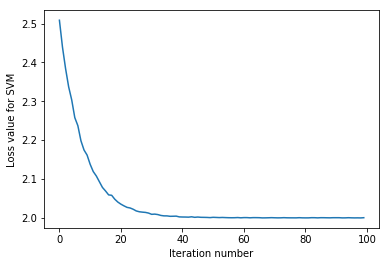

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist[0])
plt.xlabel('Iteration number')
plt.ylabel('Loss value for SVM')
plt.show()

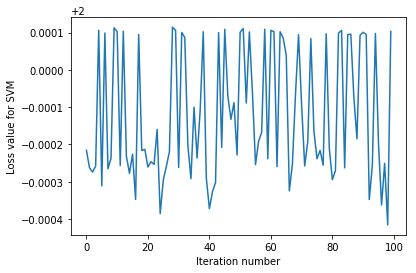

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist[1])
plt.xlabel('Iteration number')
plt.ylabel('Loss value for SVM')
plt.show()

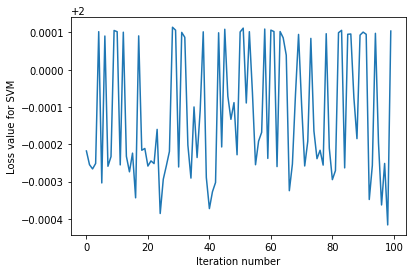

In [16]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist[2])
plt.xlabel('Iteration number')
plt.ylabel('Loss value for SVM')
plt.show()

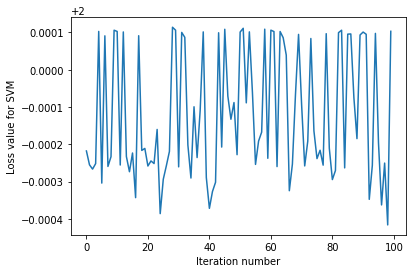

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist[3])
plt.xlabel('Iteration number')
plt.ylabel('Loss value for SVM')
plt.show()

In [28]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.700000
validation accuracy: 0.666667


In [278]:
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = [(1+i*0.1)*1e4 for i in range(-3,3)] + [(2+0.1*i)*1e4 for i in range(-3,3)]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, rs, num_iters=5000, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(lr,rs)] = train_accuracy, val_accuracy

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

TypeError: train() got an unexpected keyword argument 'num_iters'

In [175]:
from sklearn.externals import joblib
joblib.dump(best_svm, "my_model.m")

[autoreload of linear_classifier failed: Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "D:\Anaconda\lib\site-packages\IPython\extensions\autoreload.py", line 368, in superreload
    module = reload(module)
  File "D:\Anaconda\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "D:\Anaconda\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\admin\SVM\linear_classifier.py", line 78
    print 'iteration %d / %d: loss %f' % (it, num_i

['my_model.m']

In [179]:
clf = joblib.load("my_model.m")
loss_h=clf.train(X_train,y_train,num_iters=1000, verbose=True)
y_pred=clf.predict(X_test)
#print(np.mean(y_test == y_pred))
print(loss_h)
print(grad_h)

iteration 0 / 1000: loss 1.998419
iteration 100 / 1000: loss 1.068134
iteration 200 / 1000: loss 0.839038
iteration 300 / 1000: loss 0.671532
iteration 400 / 1000: loss 0.729067
iteration 500 / 1000: loss 0.662530
iteration 600 / 1000: loss 0.585267
iteration 700 / 1000: loss 0.539332
iteration 800 / 1000: loss 0.471866
iteration 900 / 1000: loss 0.442165
[1.9984194993748203, 1.9870962355171933, 1.975294125852301, 1.962769945791218, 1.9540129445637495, 1.9367526103081323, 1.927808472878543, 1.9105740479655577, 1.8963877903070157, 1.898735284079129, 1.8817565495329205, 1.861838838010963, 1.8533941573638253, 1.8353800054125087, 1.8245239387465486, 1.8191324749667546, 1.7967585193545126, 1.7837641359737022, 1.7739987853848689, 1.7545475264631845, 1.7358410815269243, 1.7190653398496885, 1.716575270515804, 1.7172603210154578, 1.6980140560177144, 1.699451226940846, 1.6829971680827611, 1.6706494610196572, 1.6517314292712366, 1.699102967832166, 1.6006429431714129, 1.630381491284468, 1.63728856

NameError: name 'grad_h' is not defined

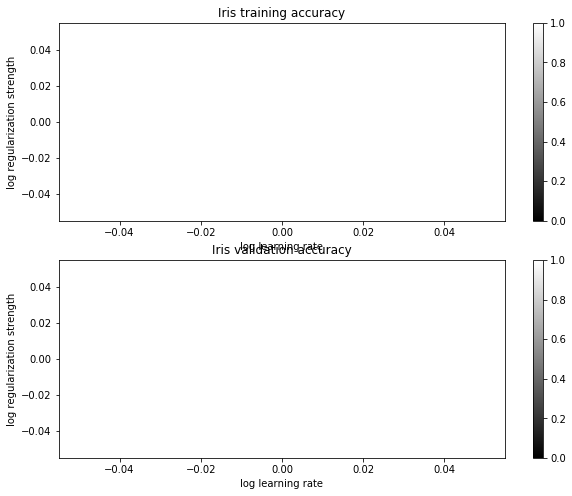

In [280]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Iris training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Iris validation accuracy')
plt.show()v   

In [293]:
# Evaluate the best svm on test set
y_test_pred = svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.684211


# 超平面图

In [294]:
print(y_test)
print(y_test_pred)

[0 0 0 0 1 1 1 0 1 2 2 2 1 2 1 0 0 2 0 1 2 1 1 0 2 0 0 1 2 1 0 1 2 2 0 1 2
 2]
[0 0 0 0 1 2 2 0 2 2 2 2 2 2 2 0 0 2 0 2 2 2 2 0 2 0 0 2 2 2 0 2 2 2 0 2 2
 2]


In [295]:
 np.mean(y_test == y_test_pred)

0.6842105263157895

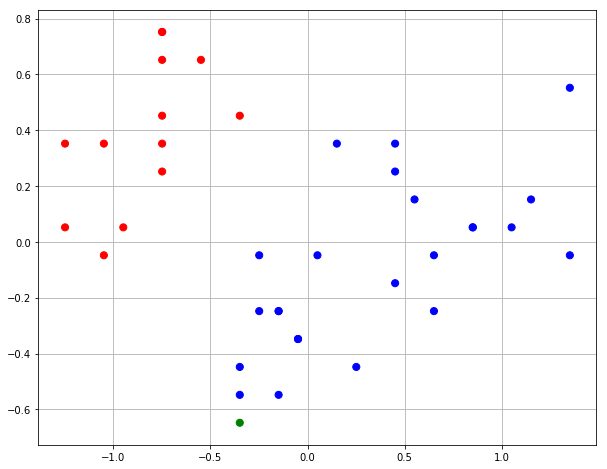

In [296]:
import numpy as np
from sklearn import model_selection as mo
from sklearn import svm
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl


cm_light = colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])
cm_dack = colors.ListedColormap(['r', 'g', 'b'])
#plt.pcolormesh(x1, x2, g_map, cmap=cm_light)
plt.scatter(X_test[:, 0], X_test[:, 1],c=np.squeeze(y_test_pred.flat), s=50, cmap=cm_dack)
plt.plot()
plt.grid()
plt.show()



In [67]:
print(iris.data[:,:2])

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]
 [5.4 3.7]
 [4.8 3.4]
 [4.8 3. ]
 [4.3 3. ]
 [5.8 4. ]
 [5.7 4.4]
 [5.4 3.9]
 [5.1 3.5]
 [5.7 3.8]
 [5.1 3.8]
 [5.4 3.4]
 [5.1 3.7]
 [4.6 3.6]
 [5.1 3.3]
 [4.8 3.4]
 [5.  3. ]
 [5.  3.4]
 [5.2 3.5]
 [5.2 3.4]
 [4.7 3.2]
 [4.8 3.1]
 [5.4 3.4]
 [5.2 4.1]
 [5.5 4.2]
 [4.9 3.1]
 [5.  3.2]
 [5.5 3.5]
 [4.9 3.1]
 [4.4 3. ]
 [5.1 3.4]
 [5.  3.5]
 [4.5 2.3]
 [4.4 3.2]
 [5.  3.5]
 [5.1 3.8]
 [4.8 3. ]
 [5.1 3.8]
 [4.6 3.2]
 [5.3 3.7]
 [5.  3.3]
 [7.  3.2]
 [6.4 3.2]
 [6.9 3.1]
 [5.5 2.3]
 [6.5 2.8]
 [5.7 2.8]
 [6.3 3.3]
 [4.9 2.4]
 [6.6 2.9]
 [5.2 2.7]
 [5.  2. ]
 [5.9 3. ]
 [6.  2.2]
 [6.1 2.9]
 [5.6 2.9]
 [6.7 3.1]
 [5.6 3. ]
 [5.8 2.7]
 [6.2 2.2]
 [5.6 2.5]
 [5.9 3.2]
 [6.1 2.8]
 [6.3 2.5]
 [6.1 2.8]
 [6.4 2.9]
 [6.6 3. ]
 [6.8 2.8]
 [6.7 3. ]
 [6.  2.9]
 [5.7 2.6]
 [5.5 2.4]
 [5.5 2.4]
 [5.8 2.7]
 [6.  2.7]
 [5.4 3. ]
 [6.  3.4]
 [6.7 3.1]
 [6.3 2.3]
 [5.6 3. ]
 [5.5 2.5]
 [5.5 2.6]